---

# **DataTour 2024 - Phase Nationale: Prévision de la Production d’Énergie Solaire en Afrique**


<center><img src="https://media.licdn.com/dms/image/v2/C5612AQHeCd5SbvoT0w/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1651615480984?e=1741219200&v=beta&t=rzJxubbYuL3vtXiZkPWtrxoAS-z6RH5ZnkvrObWmlp4" width="600"></img></center>

---

### **Contexte**
L'accès à une énergie fiable en Afrique subsaharienne reste un défi majeur. La prévision de la demande énergétique est essentielle pour optimiser l’allocation des ressources et identifier les zones prioritaires pour le développement des infrastructures solaires. Ce notebook vise à résoudre ce problème à l'aide de modèles de régression, contribuant ainsi à la mission d’améliorer l’accès à l’énergie dans ces régions.

---

### **Objectif**
Développer un modèle de régression performant pour prédire la **demande énergétique projetée** dans différentes régions, en utilisant des données géographiques, socio-économiques et environnementales.

---

### **Structure des Données**
Les données fournies sont réparties en trois fichiers :
1. **`train.csv`** : Contient 150 000 lignes et toutes les colonnes, y compris la cible. Utilisé pour entraîner le modèle.
2. **`test.csv`** : Inclut 62 500 lignes et les valeurs réelles de la cible pour ajuster et évaluer le modèle.
3. **`submission.csv`** : Fichier de 25 000 lignes sans la colonne cible, utilisé pour produire les prédictions finales.

---

### **Description des Colonnes**

| Colonne                              | Description                                                                                                    |
|--------------------------------------|----------------------------------------------------------------------------------------------------------------|
| `country`                            | Le pays où se situe la région.                                                                                 |
| `lat`, `lon`                         | Latitude et longitude de la région, permettant d'analyser les conditions géographiques.                        |
| `population`                         | Population de la région, un indicateur de la demande énergétique potentielle.                                  |
| `taux_ensoleillement`                | Moyenne du taux d'ensoleillement annuel, indiquant le potentiel solaire de la région.                          |
| `demande_energetique_actuelle`       | La demande énergétique actuelle de la région.                                                                  |
| `demande_energetique_projectee`      | **Variable cible** – La demande énergétique projetée pour la région (à prédire dans le fichier de soumission). |
| `capacite_installee_actuelle`        | La capacité énergétique actuelle installée dans la région.                                                     |
| `duree_ensoleillement_annuel`        | Nombre moyen d'heures d'ensoleillement annuel, influençant le potentiel de production solaire.                 |
| `cout_installation_solaire`          | Coût moyen pour installer des infrastructures solaires dans la région.                                        |
| `proximite_infrastructures_energetiques` | Distance aux infrastructures énergétiques existantes, influençant l'accès à l'énergie.                    |
| `taux_adoption_energies_renouvelables` | Pourcentage de la population utilisant des énergies renouvelables.                                         |
| `stabilite_politique`                | Score de stabilité politique, un facteur pouvant affecter les investissements énergétiques.                    |
| `taux_acces_energie`                 | Pourcentage de la population ayant actuellement accès à l'énergie.                                            |
| `niveau_urbanisation`                | Niveau d'urbanisation de la région, lié à l'infrastructure et à la demande en énergie.                        |
| `potentiel_investissement`           | Indicateur de l'intérêt potentiel pour des investissements énergétiques dans la région.                        |
| `types_sols`                         | Type de sol dans la région, pouvant affecter la faisabilité des infrastructures solaires.                      |
| `emissions_co2_evitees`              | Estimation des émissions de CO₂ évitées grâce aux énergies renouvelables installées.                          |
| `idh`                                | Indice de développement humain, un facteur socio-économique influençant la demande énergétique.                |
| `habit_de_mariage`                   | Tradition vestimentaire locale lors des mariages, incluse pour ajouter de la variété dans les données.         |
| `nombre_animaux_domestiques`         | Nombre moyen d'animaux domestiques par foyer, inclus pour ajouter de la variété dans les données.              |

---

### **Métrique d’Évaluation**
La performance du modèle sera mesurée à l'aide de la **Root Mean Squared Error (RMSE)**, définie comme suit :

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Où :
- $y_i$ est la valeur réelle.
- $\hat{y}_i$ est la prédiction.
- $n$ est le nombre total d'observations.

Un RMSE plus faible indique une meilleure performance du modèle.

## I. Set-up

### Installation & import des packages

In [ ]:
%%capture
!pip install sklego optuna catboost xgboost lightgbm

In [ ]:
# librairies de base
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

# preprocessing des données et métriques
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import make_pipeline

# modeles linéaires
from sklego.linear_model import LADRegression
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# modèles d'ensemble learning et arbres
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# optimisation bayésienne
import optuna

# gerer les avertissements
import warnings
warnings.simplefilter("ignore")

# garantir la reproductibilité
np.random.seed(2024)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# constantes
TARGET_COL       = 'demande_energetique_projectee'
N_FOLDS          = 5
RANDOM_STATE     = 2024

### Fonctions utilitaires (à ignorer temporairement)

La cellule suivante regroupe un ensemble de **fonctions utilitaires** qui seront utilisées tout au long du notebook pour accomplir diverses tâches, telles que l'importation des données, l'exploration, l'analyse statistique, la visualisation, ou encore l'évaluation des modèles.  

L'objectif est de rendre le notebook plus lisible et facile à suivre en évitant d'encombrer les sections principales avec du code répétitif ou complexe. Si vous souhaitez comprendre en détail le fonctionnement d'une fonction, vous pouvez toujours revenir à cette cellule pour consulter son implémentation.  

Ainsi, vous pourrez vous concentrer sur **les résultats et les analyses essentielles**, tout en ayant la possibilité de creuser davantage si nécessaire.

In [ ]:
# Fonction pour importer les datasets
def import_data(train_path, test_path, submission_path):
    """Importe les datasets d'entraînement, test et soumission depuis leurs chemins respectifs."""
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    submission = pd.read_csv(submission_path)
    return train, test, submission

# Fonction pour afficher les premières lignes des datasets
def print_first_rows(train, test, submission, n_rows=3):
    """Affiche les premières lignes des datasets d'entraînement, test et soumission."""
    print(f"First few rows Training set:")
    print("==="*8)
    print(train.head(n_rows).to_string(index=False))
    print("\n")

    print(f"First few rows Test set:")
    print("==="*8)
    print(test.head(n_rows).to_string(index=False))
    print("\n")

    print(f"First few rows Submission:")
    print("==="*8)
    print(submission.head(n_rows).to_string(index=False))
    print("\n")

# Fonction pour afficher les dimensions des datasets
def print_shapes(train, test, submission):
    """Affiche les dimensions des datasets d'entraînement, test et soumission."""
    print(f"Shape of the data:")
    print("==="*6)
    print(f"""Training: {train.shape} \nTest: {test.shape} \nSubmission: {submission.shape}""")
    print("\n")

# Fonction pour afficher les doublons dans les datasets
def print_duplicated(train, test, submission):
    """Affiche le nombre de doublons dans les datasets d'entraînement, test et soumission."""
    print(f"Number of duplicated values:")
    print("==="*9)
    print(f"""Training: {train.duplicated().sum()} \nTest: {test.duplicated().sum()} \nSubmission: {train.duplicated().sum()}""")
    print("\n")

# Fonction pour afficher les valeurs manquantes d'un dataset
def print_missing(df, df_name="Train"):
    """Affiche le nombre de valeurs manquantes par colonne dans un dataset donné."""
    print(f"Number of missing values by cols in {df_name}:")
    print("==="*15)
    print(f"""{df.isna().sum().sort_values(ascending=False)}""")
    print("\n")

# Fonction pour afficher les valeurs d'une colonne catégorielle
def print_value_counts(df, cols):
    """Affiche le nombre de valeurs uniques dans chaque colonne catégorielle spécifiée."""
    print("Number of values in each categorical column:")
    print("==" * 18)
    for col in cols:
        print(f"{df[col].value_counts()}")
        print("==" * 15)
    print("\n")

# Fonction pour calculer des statistiques univariées
def univariate_stats(df):
    """Calcule des statistiques univariées pour les colonnes numériques et catégorielles."""
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

# Fonction intermédiaire pour effectuer un test ANOVA
def anova(df, feature, label):
    """Effectue un test ANOVA unidirectionnel pour une caractéristique donnée."""
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])

    return stats.f_oneway(*group_labels)

# Fonction pour calculer des statistiques bivariées
def bivstats(df, label=TARGET_COL):
    """Calcule des statistiques bivariées (corrélation, ANOVA) pour chaque colonne par rapport à une cible."""
    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])
    for col in df:
        if col != label:
            if df[col].isnull().sum() == 0:
                if is_numeric_dtype(df[col]):
                    r, p = stats.pearsonr(df[label], df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F, 3), round(p,6)]
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, np.nan]
    return output_df.sort_values(by=['Effect size', 'Stat'], ascending=[False, False])

# Fonction pour tracer une courbe de densité
def plot_kde_distribution(df, target_col, figsize=(6, 6), color='steelblue', title=''):
    """Trace une courbe de densité pour une colonne cible dans un dataset."""
    fig, ax = plt.subplots(figsize=figsize)
    sns.kdeplot(ax=ax, data=df, x=target_col, fill=True, color=color).set_title(title)
    plt.show()

# Fonction pour tracer des histogrammes
def plot_histograms(df_train, df_test, target_col=TARGET_COL, n_cols=3):
    """Trace des histogrammes pour comparer les colonnes des datasets d'entraînement et de test."""
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()
    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        ax.set_title(f'{var_name} Distribution')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Fonction pour tracer des boxplots
def plot_boxplot(df, title='', drop_cols=TARGET_COL, n_cols=3):
    """Trace des boxplots pour les colonnes du dataset donné."""
    sns.set_style('darkgrid')
    cols = df.columns
    n_rows = (len(cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
    df = df.reset_index(drop=True)
    for i, var_name in enumerate(cols):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]
        sns.boxplot(data=df, y=var_name, ax=ax, showmeans=True,
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name}')
    fig.suptitle(f'{title} boxplot', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

# Fonction pour détecter les valeurs aberrantes
def detect_outliers(df, feature):
    """Détecte les valeurs aberrantes d'une caractéristique en utilisant la méthode IQR."""
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    outliers = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)]
    return outliers, upper_limit, lower_limit

# Fonction pour évaluer un modèle
def evaluate_model(model, X_val, Y_val, cv_scores, model_name="Model"):
    """Évalue un modèle sur des données de validation et affiche les scores CV et RMSE."""
    cv_score = np.mean(cv_scores)
    print(f"{model_name} - Score on CV test data ======> {cv_score}")
    preds_val = model.predict(X_val)
    val_score = root_mean_squared_error(Y_val, preds_val)
    print(f"{model_name} - Score on Valid data (unseen data) ======> {val_score}")
    return {"cv_score": cv_score, "val_score": val_score}

### Importation des données

In [ ]:
# files path
train_path       = "https://raw.githubusercontent.com/dataafriquehub/energy_data/refs/heads/main/train.csv"
test_path        = "https://raw.githubusercontent.com/dataafriquehub/energy_data/refs/heads/main/test.csv"
submission_path  = "https://raw.githubusercontent.com/dataafriquehub/energy_data/refs/heads/main/submission.csv"

train, test, submission = import_data(train_path, test_path, submission_path)

Il nous a été fourni un test set dans l'objectif d'ajuster et d'évaluer nos modèles. Après des analyses approfondies, nous avons pu démontrer que les variables dans les datasets de train et de test ont les mêmes distributions et qu'il serait plus bénéfique de rajouter le test set à celui du train.  
Une autre raison qui justifie ce choix est la stratégie de cross validation que nous allons adopter dans la section de modélisation.

In [ ]:
df_all = pd.concat([train, test], axis=0)

## II. Analyse Exploratoire des Données - EDA

L'**EDA** est le processus d'exploration et de compréhension des données brutes afin d'identifier les tendances, les relations et les anomalies. Elle aide à poser les bases d'une modélisation robuste et pertinente, tout en mettant en évidence les caractéristiques essentielles du jeu de données.

**NB:** Étant donné le temps imparti, nous nous sommes contentés juste de simples analyses superficielles ici afin de nous concentrer sur le feature engineering et la modélisation.

In [ ]:
print_first_rows(train, test, submission, n_rows=3)

First few rows Training set:
            country      lat     lon  population  taux_ensoleillement  demande_energetique_actuelle  demande_energetique_projectee  capacite_installee_actuelle  duree_ensoleillement_annuel  cout_installation_solaire  proximite_infrastructures_energetiques  taux_adoption_energies_renouvelables  stabilite_politique  taux_acces_energie  niveau_urbanisation  potentiel_investissement types_sols  emissions_co2_evitees      idh habit_de_mariage  nombre_animaux_domestiques
           Zimbabwe -19.0154 29.1549    14862924             5.004870                    485.085906                     544.232257                   583.128945                  3936.978948                 926.985577                               15.450396                             14.282752             2.575677           67.501053            35.733884                         4    rocheux             555.209808 0.441787     traditionnel                           2
Congo (Brazzaville)  -0.2280 15

In [ ]:
print_shapes(train, test, submission)
print_duplicated(train, test, submission)

Shape of the data:
Training: (150000, 21) 
Test: (62500, 21) 
Submission: (25000, 20)


Number of duplicated values:
Training: 0 
Test: 0 
Submission: 0




### Analyse univariée

L'analyse univariée consiste à examiner une seule variable à la fois pour en étudier la distribution, la centralité (moyenne, médiane) et la dispersion (écart-type, variance) etc...

In [ ]:
# list of numerical columns and categorical columns
categ_cols   = df_all.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_all.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove(TARGET_COL)

print(f"Variables numériques: {numeric_cols}")
print(f"Variables catégorielles: {categ_cols}")

Variables numériques: ['lat', 'lon', 'population', 'taux_ensoleillement', 'demande_energetique_actuelle', 'capacite_installee_actuelle', 'duree_ensoleillement_annuel', 'cout_installation_solaire', 'proximite_infrastructures_energetiques', 'taux_adoption_energies_renouvelables', 'stabilite_politique', 'taux_acces_energie', 'niveau_urbanisation', 'potentiel_investissement', 'emissions_co2_evitees', 'idh', 'nombre_animaux_domestiques']
Variables catégorielles: ['country', 'types_sols', 'habit_de_mariage']


In [ ]:
print_missing(df_all, df_name="df_all set")
print_missing(submission, df_name="submission set")

Number of missing values by cols in df_all set:
taux_adoption_energies_renouvelables      21409
country                                       0
habit_de_mariage                              0
idh                                           0
emissions_co2_evitees                         0
types_sols                                    0
potentiel_investissement                      0
niveau_urbanisation                           0
taux_acces_energie                            0
stabilite_politique                           0
proximite_infrastructures_energetiques        0
lat                                           0
cout_installation_solaire                     0
duree_ensoleillement_annuel                   0
capacite_installee_actuelle                   0
demande_energetique_projectee                 0
demande_energetique_actuelle                  0
taux_ensoleillement                           0
population                                    0
lon                                     

In [ ]:
display(univariate_stats(df_all))

Count  Missing  Unique    Dtype  \
taux_ensoleillement                     212500        0  212500  float64   
demande_energetique_actuelle            212500        0  212500  float64   
demande_energetique_projectee           212500        0  212500  float64   
capacite_installee_actuelle             212500        0  212500  float64   
duree_ensoleillement_annuel             212500        0  212500  float64   
cout_installation_solaire               212500        0  212500  float64   
proximite_infrastructures_energetiques  212500        0  212500  float64   
stabilite_politique                     212500        0  212500  float64   
taux_acces_energie                      212500        0  212500  float64   
niveau_urbanisation                     212500        0  212500  float64   
emissions_co2_evitees                   212500        0  212500  float64   
idh                                     212500        0  212500  float64   
taux_adoption_energies_renouvelables    191091    21409  191091  float64   
lat                                     212500        0      53  float64   
lon                                     212500        0      53  float64   
population                              212500        0      53    int64   
nombre_animaux_domestiques              212500        0      10    int64   
potentiel_investissement                212500        0       5    int64   
country                                 212500        0      53   object   
types_sols                              212500        0       3   object   
habit_de_mariage                        212500        0       2   object   

                                        IsNumeric         Mode  \
taux_ensoleillement                          True     4.000027   
demande_energetique_actuelle                 True   100.016363   
demande_energetique_projectee                True   107.515374   
capacite_installee_actuelle                  True    50.004456   
duree_ensoleillement_annuel                  True  2000.007113   
cout_installation_solaire                    True   800.001077   
proximite_infrastructures_energetiques       True     0.001068   
stabilite_politique                          True     1.000025   
taux_acces_energie                           True    10.000116   
niveau_urbanisation                          True    20.000187   
emissions_co2_evitees                        True      0.14735   
idh                                          True     0.300001   
taux_adoption_energies_renouvelables         True     0.000256   
lat                                          True      15.4542   
lon                                          True      18.7322   
population                                   True     16425864   
nombre_animaux_domestiques                   True            4   
potentiel_investissement                     True            5   
country                                     False         Chad   
types_sols                                  False      rocheux   
habit_de_mariage                            False      moderne   

                                                   Mean          Min  \
taux_ensoleillement                             5.49888     4.000027   
demande_energetique_actuelle                2552.559545   100.016363   
demande_energetique_projectee               3893.342868   107.515374   
capacite_installee_actuelle                 1024.738895    50.004456   
duree_ensoleillement_annuel                 3000.954531  2000.007113   
cout_installation_solaire                   1149.718777   800.001077   
proximite_infrastructures_energetiques         49.89871     0.001068   
stabilite_politique                            5.502429     1.000025   
taux_acces_energie                            50.030215    10.000116   
niveau_urbanisation                            45.01984    20.000187   
emissions_co2_evitees                       4986.031689      0.14735   
idh                                            0.55

In [ ]:
display(univariate_stats(submission))

Count  Missing  Unique    Dtype  \
taux_ensoleillement                     25000        0   25000  float64   
demande_energetique_actuelle            25000        0   25000  float64   
capacite_installee_actuelle             25000        0   25000  float64   
duree_ensoleillement_annuel             25000        0   25000  float64   
cout_installation_solaire               25000        0   25000  float64   
proximite_infrastructures_energetiques  25000        0   25000  float64   
stabilite_politique                     25000        0   25000  float64   
taux_acces_energie                      25000        0   25000  float64   
niveau_urbanisation                     25000        0   25000  float64   
emissions_co2_evitees                   25000        0   25000  float64   
idh                                     25000        0   25000  float64   
taux_adoption_energies_renouvelables    22507     2493   22507  float64   
lat                                     25000        0      53  float64   
lon                                     25000        0      53  float64   
population                              25000        0      53    int64   
nombre_animaux_domestiques              25000        0      10    int64   
potentiel_investissement                25000        0       5    int64   
country                                 25000        0      53   object   
types_sols                              25000        0       3   object   
habit_de_mariage                        25000        0       2   object   

                                        IsNumeric        Mode            Mean  \
taux_ensoleillement                          True    4.000094        5.495622   
demande_energetique_actuelle                 True  100.029662     2556.349268   
capacite_installee_actuelle                  True   50.348063     1025.065707   
duree_ensoleillement_annuel                  True  2000.01884     3004.251405   
cout_installation_solaire                    True  800.000104     1148.700775   
proximite_infrastructures_energetiques       True    0.007022       50.063604   
stabilite_politique                          True     1.00042        5.512567   
taux_acces_energie                           True   10.003531       50.152244   
niveau_urbanisation                          True    20.00509       45.040662   
emissions_co2_evitees                        True    0.091219     5012.100459   
idh                                          True    0.300019         0.54981   
taux_adoption_energies_renouvelables         True    0.004767       25.040348   
lat                                          True     21.0079        3.178562   
lon                                          True    -10.9408       16.362863   
population                                   True     4649658  24764658.65608   
nombre_animaux_domestiques                   True           7         4.50324   
potentiel_investissement                     True           3         3.00436   
country                                     False  Mauritania               -   
types_sols                                  False     rocheux               -   
habit_de_mariage                            False     moderne               -   

                                               Min          25%       Median  \
taux_ensoleillement                       4.000094     4.742757     5.499037   
demande_energetique_actuelle            100.029662  1347.464722  2550.957764   
capacite_installee_actuelle              50.348063   534.943418   1025.92525   
duree_ensoleillement_annuel             2000.01884  2504.575517  3010.046404   
cout_installation_solaire               800.000104   971.906122  1147.215475   
proximite_infrastructures_energetiques    0.007022    25.126967    50.132362   
stabilite_politique                        1.00042     3.233146     5.521813   
taux_acces_energie                       10.003531    29.882332    50.129485   
niveau_urbanisation                       

In [ ]:
categorical_cols_to_display = ['potentiel_investissement', 'types_sols', 'habit_de_mariage', 'nombre_animaux_domestiques']
print_value_counts(train, categorical_cols_to_display)

Number of values in each categorical column:
potentiel_investissement
3    30135
4    30058
5    30039
1    29941
2    29827
Name: count, dtype: int64
types_sols
rocheux       50081
argileux      49995
sablonneux    49924
Name: count, dtype: int64
habit_de_mariage
traditionnel    75010
moderne         74990
Name: count, dtype: int64
nombre_animaux_domestiques
1    15141
3    15092
5    15059
4    15051
7    15020
9    15004
8    15002
2    14918
6    14892
0    14821
Name: count, dtype: int64




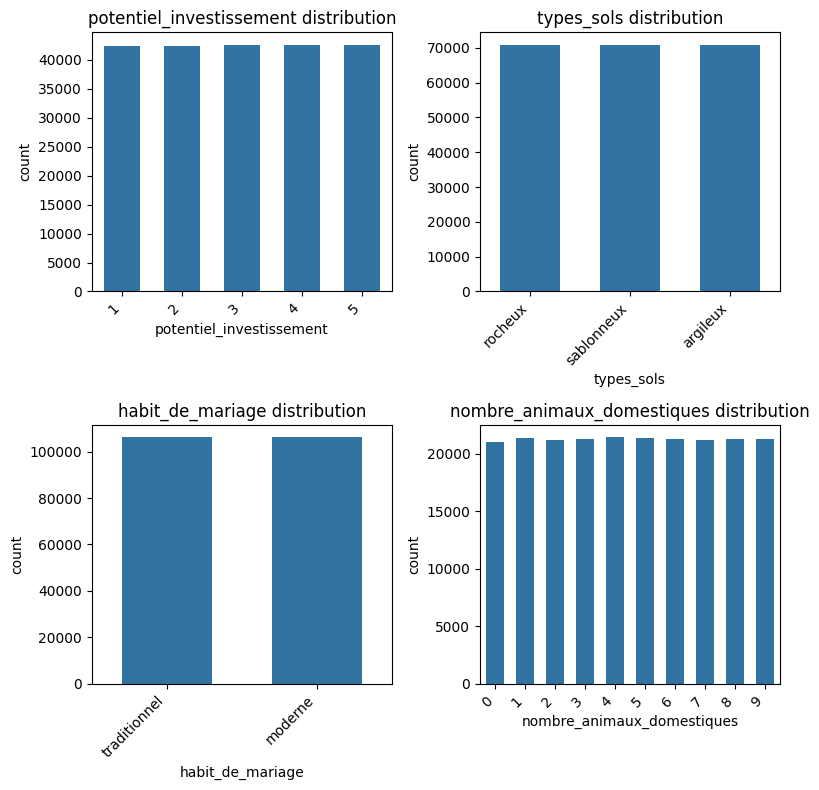

In [ ]:
plot_counts(df_all, categorical_cols_to_display)

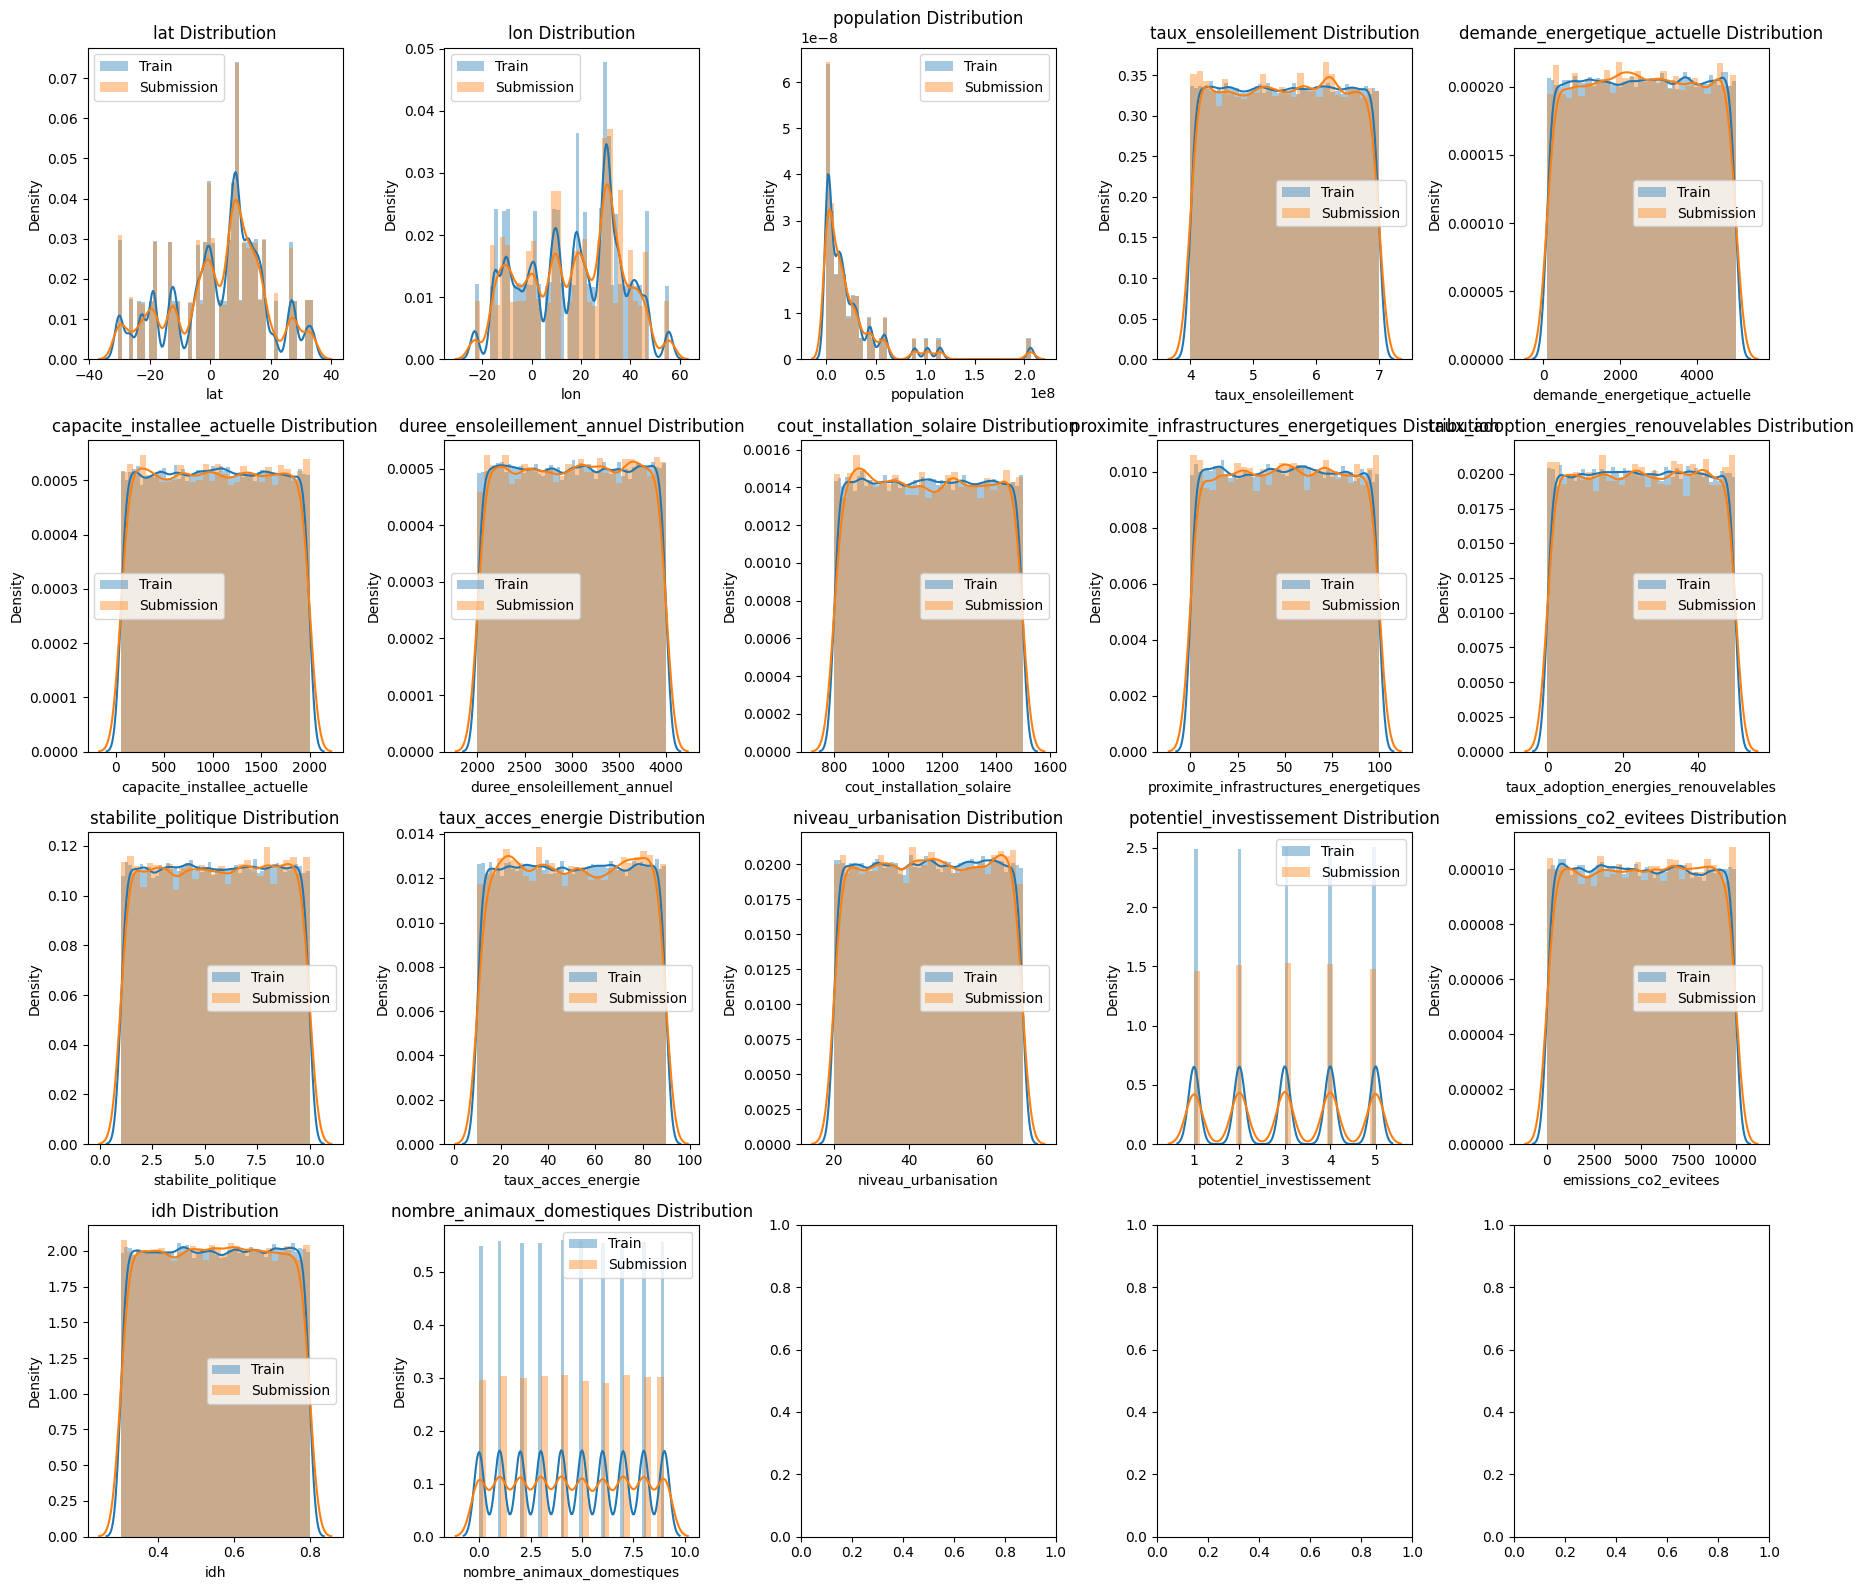

In [ ]:
plot_histograms(df_all[numeric_cols], submission[numeric_cols], TARGET_COL, n_cols=5)

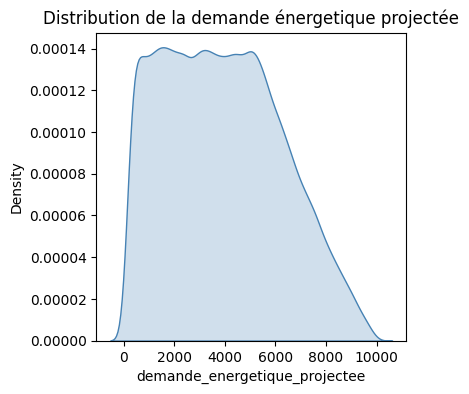

In [ ]:
plot_kde_distribution(train, figsize=(4, 4),  target_col=TARGET_COL, title='Distribution de la demande énergetique projectée')

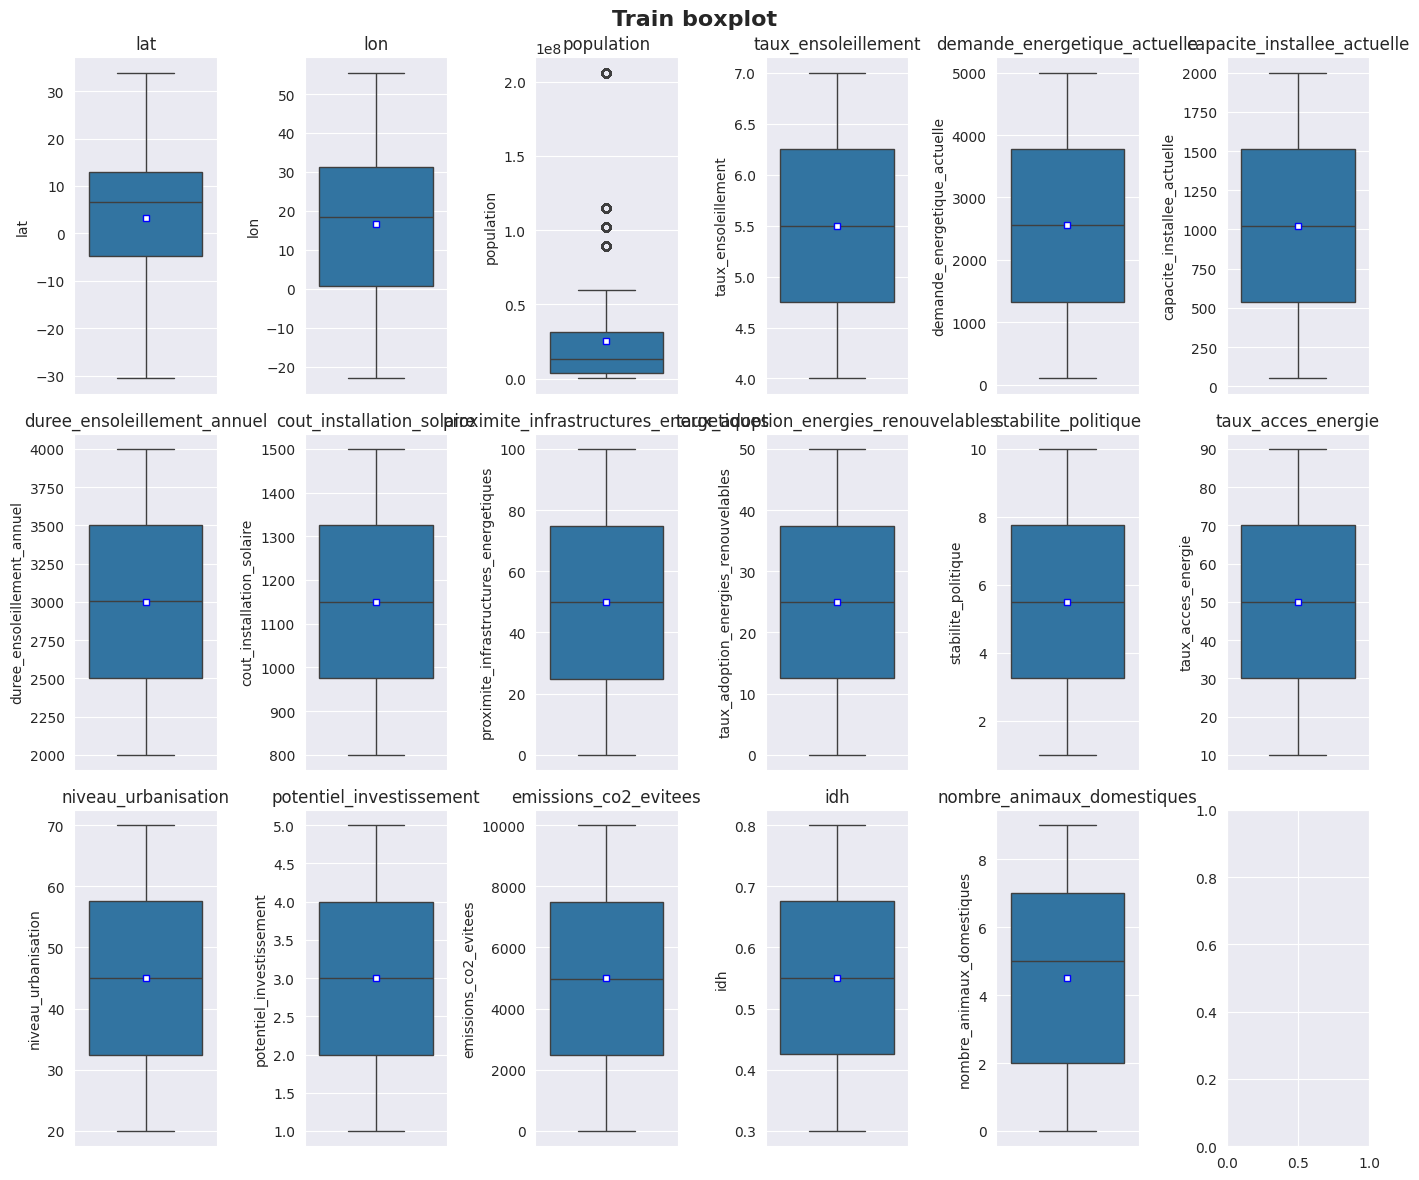

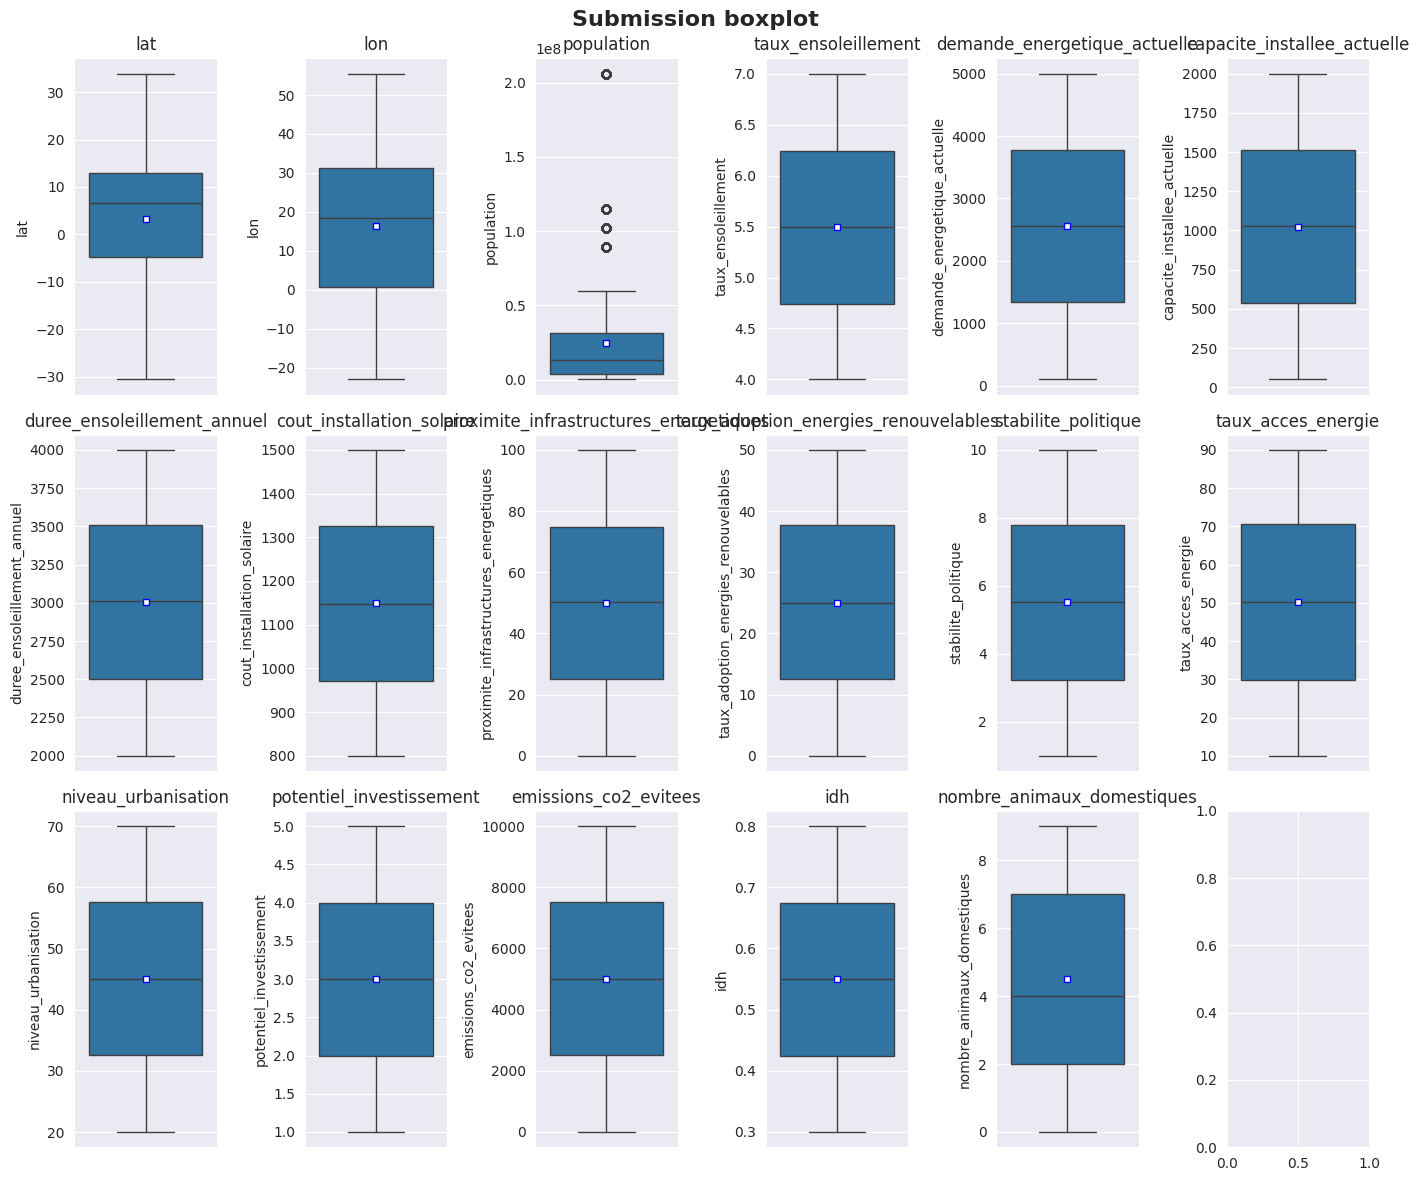

In [ ]:
plot_boxplot(df_all[numeric_cols], title='Train', n_cols=6)
plot_boxplot(submission[numeric_cols], title='Submission', n_cols=6)

### Analyse Bivariée

L'analyse bivariée examine les relations entre deux variables. Elle est utilisée pour identifier des corrélations, des interactions ou des dépendances potentielles.

In [ ]:
df_all.groupby('country')[['demande_energetique_actuelle', 'demande_energetique_projectee']].mean()

demande_energetique_actuelle  \
country                                                  
Algeria                                    2553.716602   
Angola                                     2541.573676   
Benin                                      2567.710708   
Botswana                                   2520.373142   
Burkina Faso                               2538.336239   
Burundi                                    2568.705566   
Cameroon                                   2539.305683   
Cape Verde                                 2566.355139   
Central African Republic                   2562.272026   
Chad                                       2586.928862   
Comoros                                    2616.988765   
Congo (Brazzaville)                        2576.769277   
Congo (Kinshasa)                           2533.706430   
Côte d'Ivoire                              2517.523176   
Djibouti                                   2513.839896   
Egypt                                      2549.837483   
Equatorial Guinea                          2519.600957   
Eritrea                                    2560.666532   
Eswatini (Swaziland)                       2531.687200   
Ethiopia                                   2577.471012   
Gabon                                      2559.278371   
Gambia                                     2570.501519   
Ghana                                      2571.850362   
Guinea                                     2551.506477   
Guinea-Bissau                              2573.427979   
Kenya                                      2569.514299   
Lesotho                                    2547.155362   
Liberia                                    2519.812448   
Libya                                      2553.303325   
Madagascar                                 2522.081685   
Malawi                                     2528.042267   
Mali                                       2565.191003   
Mauritania                                 2506.295322   
Morocco                                    2549.283868   
Mozambique                                 2551.825186   
Namibia                                    2558.077328   
Niger                                      2554.435568   
Nigeria                                    2587.218405   
Rwanda                                     2562.103956   
Sao Tome and Principe                      2552.904820   
Senegal                                    2542.442017   
Seychelles                                 2541.204347   
Sierra Leone                               2515.963085   
Somalia                                    2522.104709   
South Africa                               2572.850604   
South Sudan                                2535.544094   
Sudan                                      2597.792466   
Tanzania                                   2565.666123   
Togo                                       2542.027040   
Tunisia                                    2583.553890   
Uganda                                     2540.832744   
Zambia                                     2567.452977   
Zimbabwe                                   2556.035509   

                          demande_energetique_projectee  
country                                                  
Algeria                                     3885.245303  
Angola                                      3865.348804  
Benin                                       3914.652430  
Botswana                                    3859.846984  
Burkina Faso                                3854.898451  
Burundi                                     3906.450521  
Cameroon                                    3870.731111  
Cape Verde                                  3905.335028  
Central African Republic                    3894.051626  
Chad                                        3965.850637  
Comoros                                     3995.285798  
Congo (Brazzaville)                         3910.324001  
Congo (Kinshasa)       

In [ ]:
diff_demande_energetique = train['demande_energetique_projectee'] - train['demande_energetique_actuelle']

print(f""" Quelle Différence entre demande_energetique_projectee et demande_energetique_actuelle?
\n\tMoyenne de la diff: {diff_demande_energetique.mean()}, \n\tEcart type de la diff: {diff_demande_energetique.std()}""")

 Quelle Différence entre demande_energetique_projectee et demande_energetique_actuelle?

	Moyenne de la diff: 1341.2051519931033, 
	Ecart type de la diff: 1093.2217385125257


In [ ]:
df_all.groupby("country")["population"].mean().sort_values(ascending=False)

country
Nigeria                     206139589.0
Ethiopia                    114963588.0
Egypt                       102334404.0
Congo (Kinshasa)             89561403.0
Tanzania                     59734218.0
South Africa                 59308690.0
Kenya                        53771296.0
Uganda                       45741007.0
Algeria                      43851044.0
Sudan                        43849260.0
Morocco                      36910560.0
Angola                       32866272.0
Mozambique                   31255435.0
Ghana                        31072940.0
Madagascar                   27691018.0
Cameroon                     26545863.0
Côte d'Ivoire                26378274.0
Niger                        24206644.0
Burkina Faso                 20903273.0
Mali                         20250833.0
Malawi                       19129952.0
Zambia                       18383955.0
Senegal                      16743927.0
Chad                         16425864.0
Somalia                      15893222.0
Zimbabwe                     14862924.0
Guinea                       13132795.0
Rwanda                       12952218.0
Benin                        12123200.0
Burundi                      11890784.0
Tunisia                      11818618.0
South Sudan                  11193725.0
Togo                          8278724.0
Sierra Leone                  7976983.0
Libya                         6871292.0
Congo (Brazzaville)           5518092.0
Liberia                       5057681.0
Central African Republic      4829767.0
Mauritania                    4649658.0
Eritrea                       3546437.0
Namibia                       2540905.0
Gambia                        2416668.0
Botswana                      2351627.0
Gabon                         2225734.0
Lesotho                       2142249.0
Guinea-Bissau                 1968001.0
Equatorial Guinea             1402985.0
Eswatini (Swaziland)          1160164.0
Djibouti                       988000.0
Comoros                        869601.0
Cape Verde                     555987.0
Sao Tome and Principe          219159.0
Seychelles                      98347.0
Name: population, dtype: float64

In [ ]:
display(bivstats(df_all, TARGET_COL))

Stat  +/-  Effect size   p-value
country                                   F             1.059  0.358584
demande_energetique_actuelle              r  1.0        0.938  0.000000
types_sols                                F             0.136  0.873253
habit_de_mariage                          F             0.095  0.758101
taux_ensoleillement                       r -1.0        0.004  0.097526
population                                r  1.0        0.003  0.126627
niveau_urbanisation                       r -1.0        0.003  0.149428
nombre_animaux_domestiques                r  1.0        0.003  0.207453
potentiel_investissement                  r -1.0        0.002  0.359324
emissions_co2_evitees                     r -1.0        0.002  0.356321
lat                                       r  1.0        0.001  0.728689
lon                                       r  1.0        0.001  0.748916
capacite_installee_actuelle               r -1.0        0.001  0.530157
duree_ensoleillement_annuel               r  1.0        0.001  0.732673
cout_installation_solaire                 r  1.0        0.001  0.615639
proximite_infrastructures_energetiques    r  1.0        0.001  0.638611
stabilite_politique                       r  1.0        0.001  0.701413
taux_acces_energie                        r -1.0        0.001  0.566141
idh                                       r  1.0        0.000  0.930783
taux_adoption_energies_renouvelables    NaN  NaN          NaN       NaN

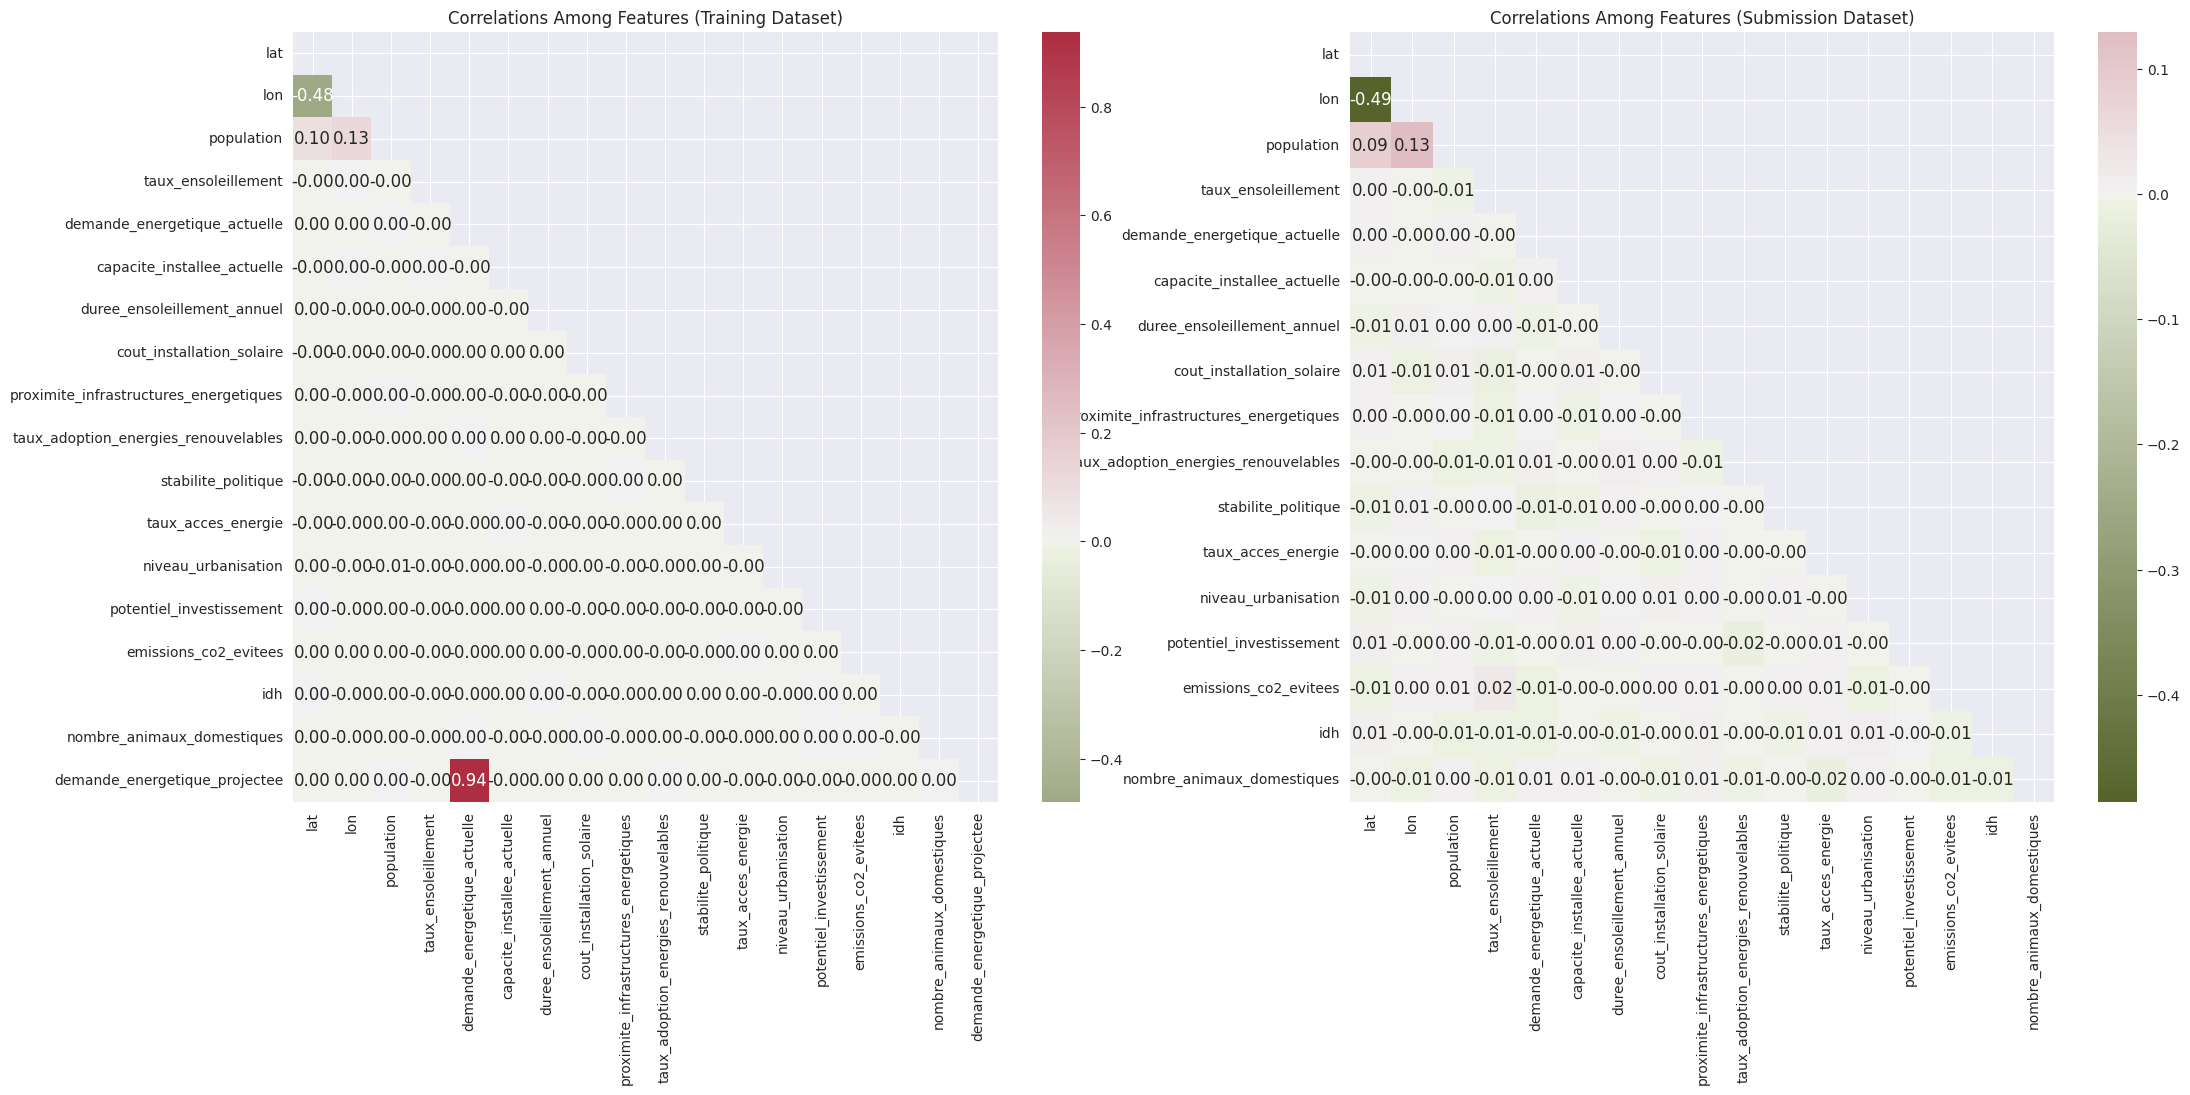

In [ ]:
plot_correlation_heatmaps(df_all=df_all, submission=submission, numeric_cols=numeric_cols, target_col=TARGET_COL)

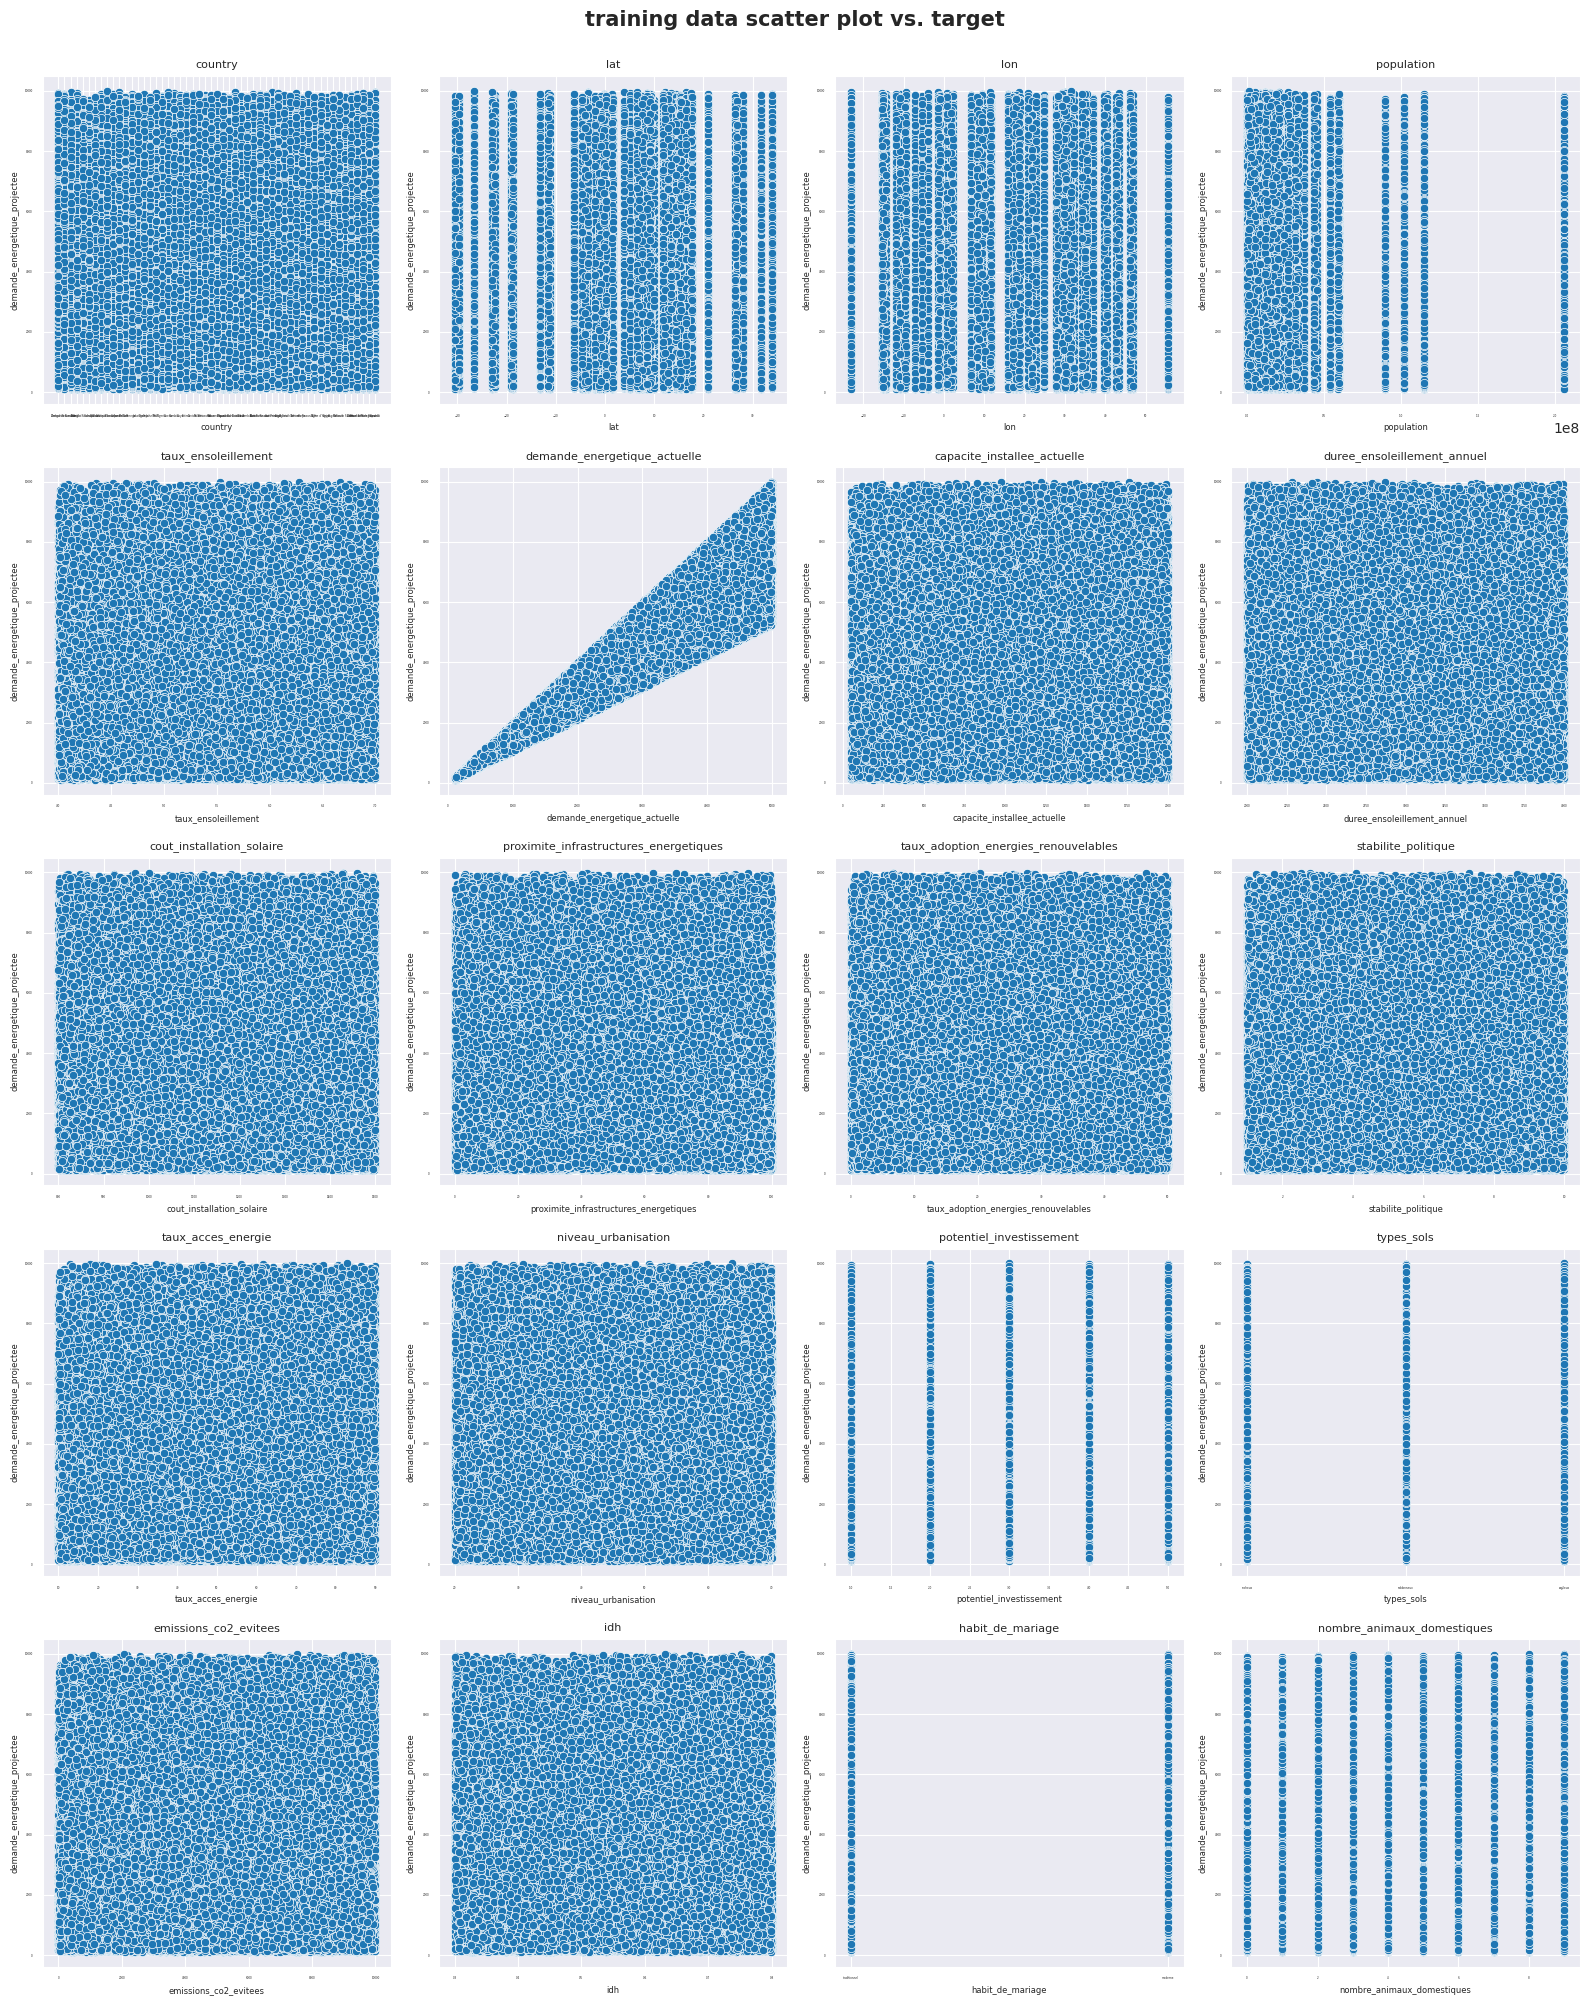

In [ ]:
plot_scatter_with_fixed_col(df_all, fixed_col=TARGET_COL, size=16, title='Train+Test data')

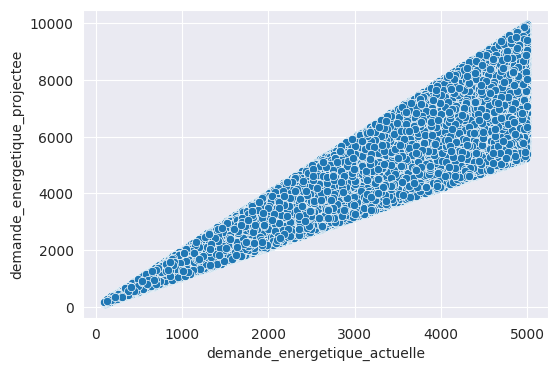

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_all, x="demande_energetique_actuelle", y="demande_energetique_projectee");

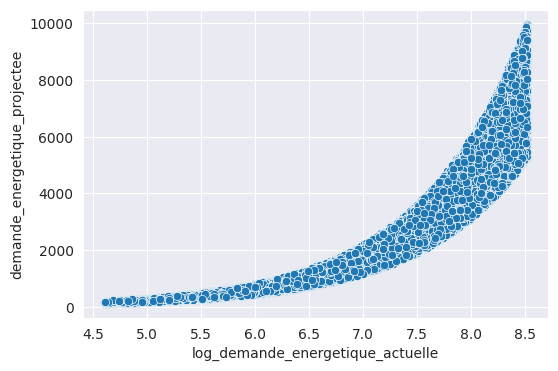

In [ ]:
temp_data = df_all.copy()
const = 0
temp_data["log_demande_energetique_actuelle"] = np.log(temp_data["demande_energetique_actuelle"]) + const

plt.figure(figsize=(6, 4))
sns.scatterplot(data=temp_data, x="log_demande_energetique_actuelle", y="demande_energetique_projectee");

INTERESTING!!!

Les principales remarques qui ressortent de cette analyse rapide :
- il y a assez peu de valeurs manquantes et de valeurs aberrantes dans le dataset (ce qui est déjà bien)
- les datasets de train et de soumission proviennent des mêmes distributions - voir graphique des histogrammes (même pas besoin de faire de tests supplémentaires comme l'adversial validation pour vérifier cette similarité)
- les variables sont très peu corrélées entre elles et les variables indépendantes sont peu corrélées à la variable cible. **Enfin à un seul détail près:** la variable **`demande_energetique_actuelle`**.

**A voir le nuage de points entre la demande énergétique actuelle et celle projetée, il semblerait (c'est une hypothèse) que la variable cible `demande_energetique_projectee` est été générée d'une certaine manière (probablement à partir d'un processus aléatoire ou une loi dont nous ignorons) à partir de la variable `demande_energetique_actuelle`.**

## III. Feature Engineering

Nous avons essayé plusieurs idées tentées pour l'ingénieries des variables mais beaucoup d'entre elles n'ont pas amélioré le score de validation... entre autres:


**Ce qui n'a pas amélioré le score:**
- label encoding de la variable country en fonction de la colonne demande_energetique_actuelle
- imputation des valeurs manquantes dans la variable `taux_adoption_energies_renouvelables` avec la méthode de KNNImputer
- suppression des quelques valeurs abérrantes en utilisant la méthode de l'IQR
- Feature engineering en rajoutant de nouvelles variables à partir de celles existantes
- ACP + Utilisation uniquement des composantes principales choisies


**Ce qui a amélioré le score:**
- suppression de la variable `country`

- ACP + addition des composantes principales aux variables initiales (bizarre ici puisque qu'il y aura une redondance des informations mais c'est le score qui parle :))

In [ ]:
columns_to_drop = ['country']
df_all     = df_all.drop(columns=columns_to_drop, axis=1)
submission = submission.drop(columns=columns_to_drop, axis=1)

df_all.shape, submission.shape

((212500, 20), (25000, 19))

### Encodage des variables catégorielles

In [ ]:
# label encoding de la variable country en fonction de la colonne demande_energetique_actuelle

# colonne d'index pour conserver l'ordre initial
#df_all = X.reset_index(drop=False).rename(columns={'index': 'original_index'})

#X = X.sort_values(by='demande_energetique_actuelle', ascending=False)
#label_encoder = LabelEncoder()

In [ ]:
# label encode country column
#df_all['country'] = label_encoder.fit_transform(df_all['country'])

df_all_prep = df_all.copy()

# one hot encode other categorical variables
df_all_prep = pd.get_dummies(df_all_prep, columns=['types_sols', 'habit_de_mariage'], drop_first=True)

print(f"""shapes:
\n\t initial: {df_all.shape},
\n\t transformed: {df_all_prep.shape}\n""")
print("===="*15)

df_all_prep.head(3)

shapes:

	 initial: (212500, 20),

	 transformed: (212500, 21)



lat      lon  population  taux_ensoleillement  \
0 -19.0154  29.1549    14862924             5.004870   
1  -0.2280  15.8277     5518092             4.609972   
2 -22.9576  18.4904     2540905             5.792826   

   demande_energetique_actuelle  demande_energetique_projectee  \
0                    485.085906                     544.232257   
1                   1422.802172                    1864.048290   
2                   4711.082367                    5525.433108   

   capacite_installee_actuelle  duree_ensoleillement_annuel  \
0                   583.128945                  3936.978948   
1                   163.908475                  3753.749894   
2                  1404.435659                  3804.854034   

   cout_installation_solaire  proximite_infrastructures_energetiques  ...  \
0                 926.985577                               15.450396  ...   
1                 862.739803                                1.461833  ...   
2                1298.932535                               17.135819  ...   

   stabilite_politique  taux_acces_energie  niveau_urbanisation  \
0             2.575677           67.501053            35.733884   
1             2.747196           61.851008            40.134654   
2             3.091990           17.384882            46.964564   

   potentiel_investissement  emissions_co2_evitees       idh  \
0                         4             555.209808  0.441787   
1                         2            3722.310275  0.380139   
2                         5            9824.421047  0.678362   

   nombre_animaux_domestiques  types_sols_rocheux  types_sols_sablonneux  \
0                           2                True                  False   
1                           5               False                   True   
2                           0               False                  False   

   habit_de_mariage_traditionnel  
0                           True  
1                           True  
2                          False  

[3 rows x 21 columns]

In [ ]:
# label encode country column
#submission['country'] = label_encoder.transform(submission['country'])
submission_prep = submission.copy()

# one hot encode other categorical variables
submission_prep = pd.get_dummies(submission_prep, columns=['types_sols', 'habit_de_mariage'], drop_first=True)

print(f"""shapes:
\n\t initial: {submission.shape},
\n\t transformed: {submission_prep.shape}\n""")
print("===="*15)
submission_prep.head(3)

shapes:

	 initial: (25000, 19),

	 transformed: (25000, 20)



lat      lon  population  taux_ensoleillement  \
0  8.4606 -11.7799     7976983             6.016310   
1  8.4606 -11.7799     7976983             6.410925   
2  6.8769  31.3069    11193725             4.642565   

   demande_energetique_actuelle  capacite_installee_actuelle  \
0                   2288.205830                  1506.365949   
1                   2402.680846                  1878.297944   
2                   3996.471566                   344.400305   

   duree_ensoleillement_annuel  cout_installation_solaire  \
0                  3856.453895                1453.281847   
1                  3652.332264                1076.560589   
2                  3810.507756                 980.596863   

   proximite_infrastructures_energetiques  \
0                               56.433841   
1                               46.100498   
2                               88.583926   

   taux_adoption_energies_renouvelables  stabilite_politique  \
0                             25.196118             9.187338   
1                             27.037202             5.307233   
2                             47.880078             1.462924   

   taux_acces_energie  niveau_urbanisation  potentiel_investissement  \
0           35.022992            58.938006                         2   
1           52.154399            58.293952                         4   
2           79.302572            24.914731                         2   

   emissions_co2_evitees       idh  nombre_animaux_domestiques  \
0            9432.861305  0.722109                           3   
1            7466.567405  0.518997                           3   
2            1239.535797  0.785365                           9   

   types_sols_rocheux  types_sols_sablonneux  habit_de_mariage_traditionnel  
0               False                   True                           True  
1               False                  False                           True  
2               False                   True                          False

In [ ]:
#print the mapping between original categories (countries) and their new labels
#country_label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
#print("Country to Label Mapping:\n", country_label_mapping)

### Gestion des valeurs manquantes

In [ ]:
"""# imputer class
imputer = KNNImputer(n_neighbors=5)

X_prep = pd.DataFrame(imputer.fit_transform(X_prep), columns = X_prep.columns)
X_prep.head(3)

submission_prep = pd.DataFrame(imputer.transform(submission_prep), columns = submission_prep.columns)
submission_prep.head(3)"""

'# imputer class\nimputer = KNNImputer(n_neighbors=5)\n\nX_prep = pd.DataFrame(imputer.fit_transform(X_prep), columns = X_prep.columns)\nX_prep.head(3)\n\nsubmission_prep = pd.DataFrame(imputer.transform(submission_prep), columns = submission_prep.columns)\nsubmission_prep.head(3)'

In [ ]:
df_all_prep['taux_adoption_energies_renouvelables'] = df_all_prep.taux_adoption_energies_renouvelables.fillna(df_all_prep.taux_adoption_energies_renouvelables.mean())
submission_prep['taux_adoption_energies_renouvelables'] = submission_prep.taux_adoption_energies_renouvelables.fillna(submission_prep.taux_adoption_energies_renouvelables.mean())

print(f"Total Number of missing values: \nTraining: {df_all_prep.isna().sum().sum()}  \nSubmission: {submission_prep.isna().sum().sum()} \n\n")

Total Number of missing values: 
Training: 0  
Submission: 0 




### Gestion des valeurs abérrantes

In [ ]:
"""outliers, upper, lower = detect_outliers(df_all_prep, "population")
print("Upper limit:", upper)
print("Lower limit:", lower)
print("Outliers:\n", outliers)"""

Upper limit: 72362694.5
Lower limit: -37743317.5
Outliers:


lat      lon  population  taux_ensoleillement  \
4  -4.0383  21.7587    89561403             6.103335   
7   9.1450  40.4890   114963588             6.508536   
20  9.0820   8.6750   206139589             4.352096   

    demande_energetique_actuelle  demande_energetique_projectee  \
4                    2526.920477                    3029.604497   
7                    4688.450916                    5101.829571   
20                   2293.512973                    2532.819933   

    capacite_installee_actuelle  duree_ensoleillement_annuel  \
4                    962.398626                  3421.335117   
7                    977.034908                  3213.439546   
20                   607.702552                  2483.578026   

    cout_installation_solaire  proximite_infrastructures_energetiques  ...  \
4                 1484.398731                               59.177555  ...   
7                 1135.412784                               91.157304  ...   
20                 846.521053                               81.575568  ...   

    stabilite_politique  taux_acces_energie  niveau_urbanisation  \
4              6.572047           47.679339            63.201230   
7              8.402613           64.254224            67.624081   
20             8.708201           56.893293            38.444233   

    potentiel_investissement  emissions_co2_evitees       idh  \
4                          3            9184.154421  0.357112   
7                          4            6270.845119  0.300488   
20                         4            3830.051077  0.485110   

    nombre_animaux_domestiques  types_sols_rocheux  types_sols_sablonneux  \
4                            2               False                  False   
7                            7               False                  False   
20                           6                True                  False   

    habit_de_mariage_traditionnel  
4                           False  
7                            True  
20                           True  

[3 rows x 21 columns]

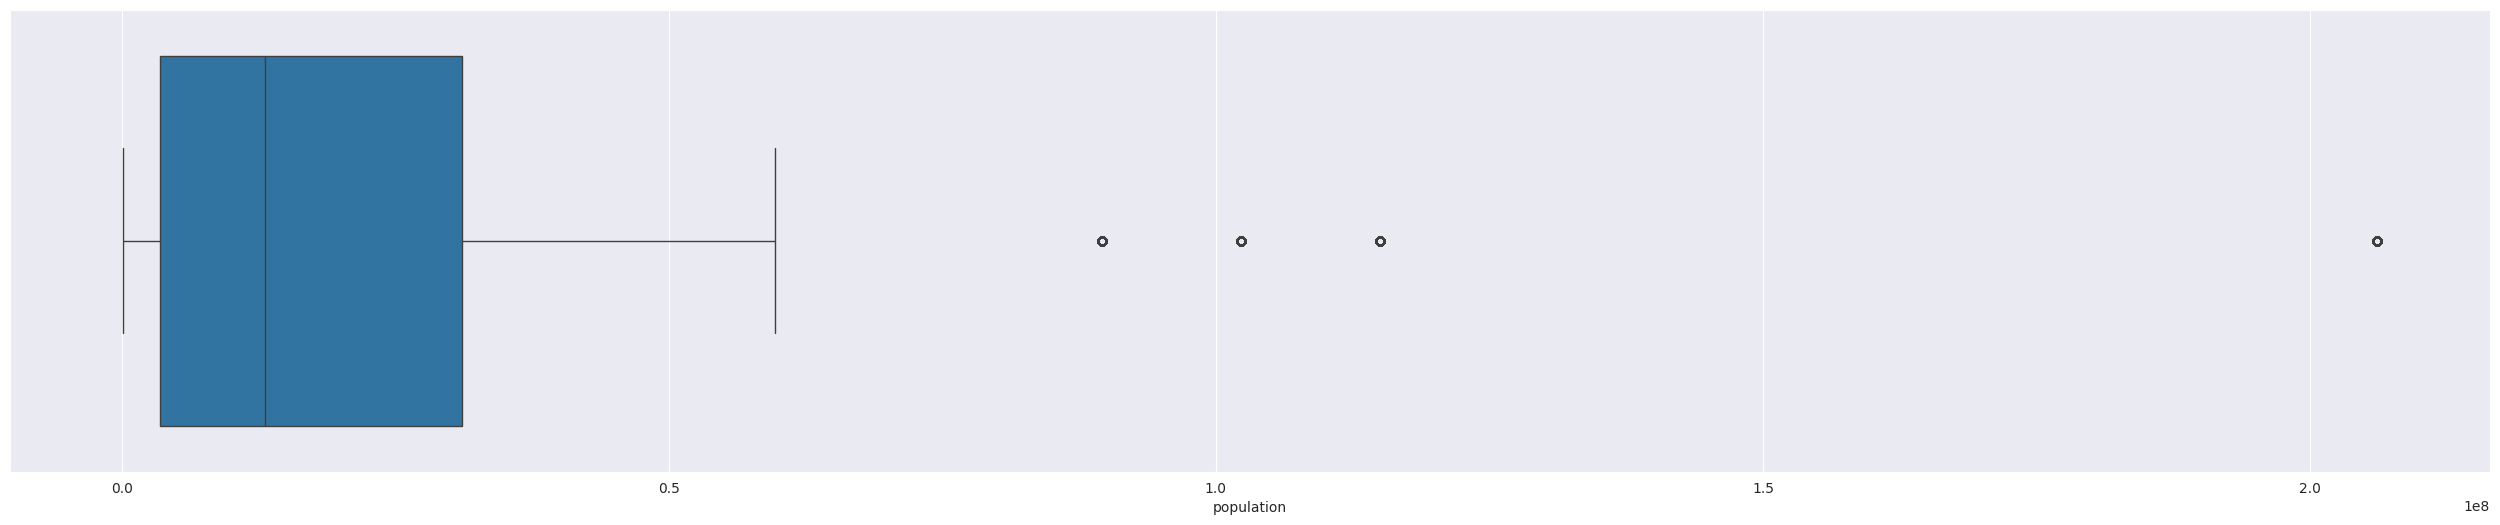

In [ ]:
#_, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 6))
#sns.boxplot(x=df_all_prep['population'], ax=ax);

# removing outliers using the above function
#df_all = df_all[(df_all['population'] > lower) & (df_all['population'] < upper)] #train
#submission = submission[(submission['population'] > lower) & (submission['population'] < upper)]     #submission

#sns.boxplot(x=train['population'], ax=ax[1])
#plt.title('population distribution before VS after removing outliers')
#plt.show()

### Ingénierie des variables

In [ ]:
# Function to add new features to the dataset
def feature_engineering(df):
    # dding brand new features
    """df['solar_efficiency'] = df['demande_energetique_actuelle'] / df['capacite_installee_actuelle']
    df['energy_cost_ratio'] = df['demande_energetique_actuelle'] / df['cout_installation_solaire']
    df['energy_adoption_interaction'] = df['demande_energetique_actuelle'] * df['taux_adoption_energies_renouvelables']
    df['infra_access_interaction'] = df['proximite_infrastructures_energetiques'] * df['taux_acces_energie']
    df['annual_solar_energy_potential'] = df['duree_ensoleillement_annuel'] * df['capacite_installee_actuelle']
    df['total_emissions_reduced'] = df['emissions_co2_evitees'] * df['taux_adoption_energies_renouvelables']
    df["log_demande_energetique_actuelle"] = np.log(df["demande_energetique_actuelle"])

    # names of the new columns
    new_cols = [
        'solar_efficiency',
        'energy_cost_ratio',
        'energy_adoption_interaction',
        'infra_access_interaction',
        'annual_solar_energy_potential',
        'total_emissions_reduced'
    ]"""

    return df #, new_cols

In [ ]:
df_all_prep = feature_engineering(df_all_prep)
submission_prep = feature_engineering(submission_prep)

df_all_prep.head(3)

lat      lon  population  taux_ensoleillement  \
0 -19.0154  29.1549    14862924             5.004870   
1  -0.2280  15.8277     5518092             4.609972   
2 -22.9576  18.4904     2540905             5.792826   

   demande_energetique_actuelle  demande_energetique_projectee  \
0                    485.085906                     544.232257   
1                   1422.802172                    1864.048290   
2                   4711.082367                    5525.433108   

   capacite_installee_actuelle  duree_ensoleillement_annuel  \
0                   583.128945                  3936.978948   
1                   163.908475                  3753.749894   
2                  1404.435659                  3804.854034   

   cout_installation_solaire  proximite_infrastructures_energetiques  ...  \
0                 926.985577                               15.450396  ...   
1                 862.739803                                1.461833  ...   
2                1298.932535                               17.135819  ...   

   stabilite_politique  taux_acces_energie  niveau_urbanisation  \
0             2.575677           67.501053            35.733884   
1             2.747196           61.851008            40.134654   
2             3.091990           17.384882            46.964564   

   potentiel_investissement  emissions_co2_evitees       idh  \
0                         4             555.209808  0.441787   
1                         2            3722.310275  0.380139   
2                         5            9824.421047  0.678362   

   nombre_animaux_domestiques  types_sols_rocheux  types_sols_sablonneux  \
0                           2                True                  False   
1                           5               False                   True   
2                           0               False                  False   

   habit_de_mariage_traditionnel  
0                           True  
1                           True  
2                          False  

[3 rows x 21 columns]

### Analyse en Composantes Principales - ACP

L'ACP est une technique de réduction de dimensionnalité qui transforme un ensemble de variables corrélées en un nouvel ensemble de variables, qui sont linéairement indépendantes. L'objectif est de capturer le maximum de variance dans les données tout en réduisant le nombre de variables.

Comme déjà mentionné, l'utilisation de l'ACP peut ne pas être très pertinente ici étant donné que les variables du dataset sont peu corrélées. Mais ici, lorsque les composantes principales ont été rajoutées au variables initiales, il y a une certaine amélioration du score.

In [ ]:
cols_for_pca = list(df_all_prep.columns)
cols_for_pca.remove('demande_energetique_projectee')
print(cols_for_pca)

['lat', 'lon', 'population', 'taux_ensoleillement', 'demande_energetique_actuelle', 'capacite_installee_actuelle', 'duree_ensoleillement_annuel', 'cout_installation_solaire', 'proximite_infrastructures_energetiques', 'taux_adoption_energies_renouvelables', 'stabilite_politique', 'taux_acces_energie', 'niveau_urbanisation', 'potentiel_investissement', 'emissions_co2_evitees', 'idh', 'nombre_animaux_domestiques', 'types_sols_rocheux', 'types_sols_sablonneux', 'habit_de_mariage_traditionnel']


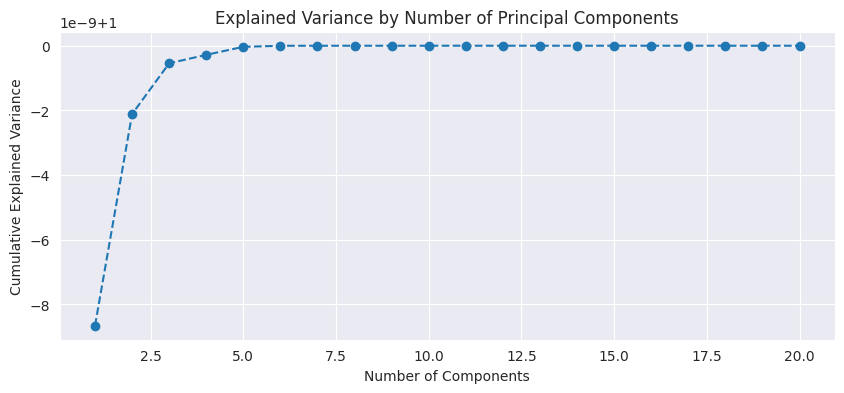

In [ ]:
pca = PCA()
pca.fit(df_all_prep[cols_for_pca])

# explained variance for each component
explained_variance = pca.explained_variance_ratio_
# cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# plot cumulative explained variance
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

In [ ]:
"""# finding the number of components to reach, say, 99% of the variance
n_components = np.argmax(cumulative_variance >= 0.99) + 1
print(f'Number of components to explain 99% variance: {n_components}')"""

"# finding the number of components to reach, say, 99% of the variance\nn_components = np.argmax(cumulative_variance >= 0.99) + 1\nprint(f'Number of components to explain 99% variance: {n_components}')"

In [ ]:
df_all_pca, submission_pca = add_pca_features(df_all_prep, submission_prep)
df_all_pca.shape, submission_pca.shape
df_all_pca.head(3)

lat      lon  population  taux_ensoleillement  \
0 -19.0154  29.1549    14862924             5.004870   
1  -0.2280  15.8277     5518092             4.609972   
2 -22.9576  18.4904     2540905             5.792826   

   demande_energetique_actuelle  demande_energetique_projectee  \
0                    485.085906                     544.232257   
1                   1422.802172                    1864.048290   
2                   4711.082367                    5525.433108   

   capacite_installee_actuelle  duree_ensoleillement_annuel  \
0                   583.128945                  3936.978948   
1                   163.908475                  3753.749894   
2                  1404.435659                  3804.854034   

   cout_installation_solaire  proximite_infrastructures_energetiques  ...  \
0                 926.985577                               15.450396  ...   
1                 862.739803                                1.461833  ...   
2                1298.932535                               17.135819  ...   

        idh  nombre_animaux_domestiques  types_sols_rocheux  \
0  0.441787                           2                True   
1  0.380139                           5               False   
2  0.678362                           0               False   

   types_sols_sablonneux  habit_de_mariage_traditionnel     PCA_0     PCA_1  \
0                  False                           True -1.586654  1.373723   
1                   True                           True  1.492601  0.143802   
2                  False                          False -0.050556  1.218872   

      PCA_2     PCA_3     PCA_4  
0 -0.540225  1.103137 -0.527500  
1 -0.740391  0.413349  0.361332  
2 -0.836402  1.521155 -1.115942  

[3 rows x 26 columns]

### Scaling/Normalization

In [ ]:
"""#scaling the data
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X))
test_eng = pd.DataFrame(scaler.transform(test_eng))
test_eng"""

'#scaling the data\nscaler = StandardScaler()\n\nX = pd.DataFrame(scaler.fit_transform(X))\ntest_eng = pd.DataFrame(scaler.transform(test_eng))\ntest_eng'

### Splitting validation data

In [ ]:
X_all = df_all_prep.drop(columns=[TARGET_COL], axis=1)
Y_all = df_all_prep[TARGET_COL]
test_eng = submission_prep #.drop(columns=columns_to_drop, axis=1)

X_all.shape, Y_all.shape, submission.shape

((212500, 25), (212500,), (25000, 19))

In [ ]:
"""X_all = df_all_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]
Y_all = df_all_pca[TARGET_COL]
test_eng = submission_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]

X_all.shape, Y_all.shape, test_eng.shape"""

"X_all = df_all_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]\nY_all = df_all_pca[TARGET_COL]\ntest_eng = submission_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]\n\nX_all.shape, Y_all.shape, test_eng.shape"

In [ ]:
X, X_val, Y, Y_val = train_test_split(X_all, Y_all, test_size=0.1, random_state=42)
X.shape, Y.shape, test_eng.shape

((191250, 25), (191250,), (25000, 25))

## IV. Modélisation

Dans notre approche de modélisation, nous utilisons la **validation croisée** pour évaluer chaque modèle de régression. Cela signifie que nous divisons nos données en plusieurs sous-ensembles (5 ici) et nous entraînons/testons chaque modèle sur différentes combinaisons de ces sous-ensembles pour obtenir une évaluation plus fiable de ses performances.

Ensuite, nous appliquons la technique de **stacking**. Au lieu d'utiliser un seul modèle, nous combinons plusieurs modèles (par exemple, régression linéaire, XGBoost, LGBM, etc.) pour prédire la variable cible. Chaque modèle fait une prédiction et ces prédictions sont ensuite utilisées comme entrée pour un modèle final (par exemple, une régression linéaire) qui décide de la prédiction finale.

Les **hyperparamètres** de chaque modèle sont optimisés à l'aide de **l'optimisation bayésienne** avec **Optuna**, une méthode qui explore automatiquement différentes configurations de paramètres pour trouver la meilleure combinaison pour chaque modèle (voir dernière section en fin de notebook).

### Définition des hyperparamatètres

In [ ]:
lasso_best_params = {'alpha': 0.9464268988662359, 'max_iter': 791, 'tol': 0.00047308177979131136, 'fit_intercept': False, 'positive': True, 'selection': 'cyclic'}
lgb_best_params   = {"objective": "rmse", "metric": "rmse", 'verbose': -1, 'num_leaves': 102, 'max_depth': 1, 'learning_rate': 0.034723637811449146, 'n_estimators': 878, 'min_child_samples': 51, 'min_child_weight': 0.012788573193490927, 'subsample': 0.8968760260635513, 'subsample_freq': 3, 'colsample_bytree': 0.8659594112847362, 'reg_alpha': 0.0018755405264117115, 'reg_lambda': 0.0020152388749633348}
hist_best_params  = {"loss":'squared_error', 'max_iter': 746, 'max_depth': 3, 'learning_rate': 0.011843975951032079, 'min_samples_leaf': 46, 'l2_regularization': 0.007300763896598253, 'max_leaf_nodes': 80, 'max_bins': 182, 'early_stopping': True, 'validation_fraction': 0.35392508436658743}
xgb_best_params   = {"objective": 'reg:squarederror', 'learning_rate': 0.006816640645251852, 'max_depth': 3, 'n_estimators': 1172}
cat_best_params   = {"loss_function": 'RMSE',  "verbose": False, "random_state": 42, "grow_policy": 'Lossguide', 'depth': 8, 'learning_rate': 0.0044579525750365395, 'iterations': 1680}

### Entrainement des modèles

In [ ]:
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds   = list(), list()
xgb_cv_scores, xgb_preds   = list(), list()
cat_cv_scores, cat_preds   = list(), list()
lr_cv_scores, lr_preds     = list(), list()
gb_cv_scores, gb_preds     = list(), list()
lr_ens_cv_scores, lr_ens_preds = list(), list()
lasso_cv_scores, lasso_preds   = list(), list()
lad_cv_scores, lad_preds       = list(), list()

imp_hist = pd.DataFrame()
imp_xgb = pd.DataFrame()

skf = KFold(n_splits = N_FOLDS, random_state = RANDOM_STATE, shuffle = True)
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    print('=====================================================================')

    #==================================================== Linear regression ====================================================#
    # entrainement
    lr_md = LinearRegression().fit(X_train, Y_train)

    # validation
    lr_pred_1 = lr_md.predict(X_test)
    lr_score_fold = root_mean_squared_error(Y_test, lr_pred_1)
    lr_cv_scores.append(lr_score_fold)

    # prediction
    lr_pred_2 = lr_md.predict(test_eng)
    lr_preds.append(lr_pred_2)
    print('Fold N°', i, '==> LR -       RMSE: ====>', lr_score_fold)

    #==================================================== Lasso Regression ====================================================#
    # entrainement
    lasso_md = Lasso(alpha=1.0, max_iter=1000, random_state=42).fit(X_train, Y_train)

    # validation
    lasso_pred_1 = lasso_md.predict(X_test)
    lasso_score_fold = root_mean_squared_error(Y_test, lasso_pred_1)
    lasso_cv_scores.append(lasso_score_fold)

    # prediction
    lasso_pred_2 = lasso_md.predict(test_eng)
    lasso_preds.append(lasso_pred_2)
    print('Fold N°', i, '==> Lasso -       RMSE: ====>', lasso_score_fold)

    #==================================================== LightGBM ==========================================================#
    # entrainement
    lgb_md = LGBMRegressor(**lgb_best_params).fit(X_train, Y_train)

    # validation
    lgb_pred_1 = lgb_md.predict(X_test)
    lgb_score_fold = root_mean_squared_error(Y_test, lgb_pred_1)
    lgb_cv_scores.append(lgb_score_fold)

    # prediction
    lgb_pred_2 = lgb_md.predict(test_eng)
    lgb_preds.append(lgb_pred_2)

    # importance des variables
    _imp = pd.DataFrame({"features": X.columns, "importance": lgb_md.feature_importances_})
    imp_hist = pd.concat([imp_hist, _imp], axis=0, ignore_index=True)
    print('Fold N°', i, '==> LightGBM -          RMSE: ====>', lgb_score_fold)

    #==================================================== HistGradientBoosting ====================================================#
    # entrainement
    hist_md = HistGradientBoostingRegressor(**hist_best_params).fit(X_train, Y_train)

    # validation
    hist_pred_1 = hist_md.predict(X_test)
    hist_score_fold = root_mean_squared_error(Y_test, hist_pred_1)
    hist_cv_scores.append(hist_score_fold)

    # prediction
    hist_pred_2 = hist_md.predict(test_eng)
    hist_preds.append(hist_pred_2)
    print('Fold N°', i, '==> HistGradient -       RMSE: ====>', hist_score_fold)

    #======================================================== XGBoost ============================================================#
    # entrainement
    xgb_md = XGBRegressor(**xgb_best_params, random_state = 42).fit(X_train, Y_train,
                                                                    #eval_set = [(X_train, Y_train), (X_test, Y_test)],
                                                                    verbose=0)
    # validation
    xgb_pred_1 = xgb_md.predict(X_test)
    xgb_score_fold = root_mean_squared_error(Y_test, xgb_pred_1)
    xgb_cv_scores.append(xgb_score_fold)

    # prediction
    xgb_pred_2 = xgb_md.predict(test_eng)
    xgb_preds.append(xgb_pred_2)
    # importance des variables
    _imp = pd.DataFrame({"features": X.columns, "importance": xgb_md.feature_importances_})
    imp_xgb = pd.concat([imp_xgb, _imp], axis=0, ignore_index=True)
    print('Fold N°', i, '==> XGBoost -        RMSE: ====>', xgb_score_fold)

    #========================================================= CatBoost ========================================================#
    # entrainement
    cat_md = CatBoostRegressor(**cat_best_params).fit(X_train, Y_train)

    # validation
    cat_pred_1 = cat_md.predict(X_test)
    cat_score_fold = root_mean_squared_error(Y_test, cat_pred_1)
    cat_cv_scores.append(cat_score_fold)

    # prediction
    cat_pred_2 = cat_md.predict(test_eng)
    cat_preds.append(cat_pred_2)
    print('Fold N°', i, '==> CatBoost       - RMSE: ====>', cat_score_fold)

    #==================================================== GradientBoostingRegressor ====================================================#
    # entrainement
    gb_md = GradientBoostingRegressor().fit(X_train, Y_train)

    # validation
    gb_pred_1 = gb_md.predict(X_test)
    gb_score_fold = root_mean_squared_error(Y_test, gb_pred_1)
    gb_cv_scores.append(gb_score_fold)

    # prediction
    gb_pred_2 = gb_md.predict(test_eng)
    gb_preds.append(gb_pred_2)
    print('Fold N°', i, '==> GradientBoostingRegressor -       RMSE: ====>', gb_score_fold)

    #========================================================= LAD Ensemble =========================================================#
    x = pd.DataFrame({
        'hist': np.round(hist_pred_1.tolist()),
        'lgb': np.round(lgb_pred_1.tolist()),
        'xgb': np.round(xgb_pred_1.tolist()),
        'cat': np.round(cat_pred_1.tolist()),
        'lr': np.round(lr_pred_1.tolist()),
        'gb': np.round(gb_pred_1.tolist()),
        'lasso': np.round(lasso_pred_1.tolist()),
    })
    y = Y_test

    x_test = pd.DataFrame({
        'hist': np.round(hist_pred_2.tolist()),
        'lgb': np.round(lgb_pred_2.tolist()),
        'xgb': np.round(xgb_pred_2.tolist()),
        'cat': np.round(cat_pred_2.tolist()),
        'lr': np.round(lr_pred_2.tolist()),
        'gb': np.round(gb_pred_2.tolist()),
        'lasso': np.round(lasso_pred_2.tolist()),
    })

    # entrainement
    lad_md = LADRegression(fit_intercept=True, positive=False).fit(x, y)

    # validation
    lad_pred = lad_md.predict(x)
    lad_score = root_mean_squared_error(y, lad_pred)
    lad_cv_scores.append(lad_score)

    # predictions
    lad_pred_test = lad_md.predict(x_test)
    lad_preds.append(lad_pred_test)
    print('Fold N°', i, '==> LAD Model ensemble - RMSE: ====>', lad_score)

    #========================================================= LinearRegression Ensemble =========================================================#
    # entrainement
    lr_ens_md = LinearRegression().fit(x, y)

    # validation
    lr_ens_pred = lr_ens_md.predict(x)
    lr_ens_score = root_mean_squared_error(y, lr_ens_pred)
    lr_ens_cv_scores.append(lr_ens_score)

    # predictions
    lr_ens_pred_test = lr_ens_md.predict(x_test)
    lr_ens_preds.append(lr_ens_pred_test)
    print('Fold N°', i, '==> Linear Regression Ensemble - RMSE: ====>', lr_ens_score)

Fold N° 0 ==> LR -       RMSE: ====> 800.0478323323008
Fold N° 0 ==> Lasso -       RMSE: ====> 800.0459532329857
Fold N° 0 ==> LightGBM -          RMSE: ====> 800.4969665448315
Fold N° 0 ==> HistGradient -       RMSE: ====> 800.4760037021326
Fold N° 0 ==> XGBoost -        RMSE: ====> 800.4820592958251
Fold N° 0 ==> CatBoost       - RMSE: ====> 800.4903985085359
Fold N° 0 ==> GradientBoostingRegressor -       RMSE: ====> 800.7503151160855
Fold N° 0 ==> LAD Model ensemble - RMSE: ====> 799.9958018621405
Fold N° 0 ==> Linear Regression Ensemble - RMSE: ====> 799.9178431985086
Fold N° 1 ==> LR -       RMSE: ====> 800.0846672852615
Fold N° 1 ==> Lasso -       RMSE: ====> 800.0548374612667
Fold N° 1 ==> LightGBM -          RMSE: ====> 800.6341053378588
Fold N° 1 ==> HistGradient -       RMSE: ====> 800.769636262636
Fold N° 1 ==> XGBoost -        RMSE: ====> 800.3606624707709
Fold N° 1 ==> CatBoost       - RMSE: ====> 800.2413706800992
Fold N° 1 ==> GradientBoostingRegressor -       RMSE: ===

### Evaluation des modèles

In [ ]:
# list of models, their names, and their respective CV scores
models = [
    {"name": "Linear Regression", "model": lr_md, "cv_scores": lr_cv_scores},
    {"name": "Lasso", "model": lasso_md, "cv_scores": lasso_cv_scores},
    {"name": "Gradient Boosting", "model": gb_md, "cv_scores": gb_cv_scores},
    {"name": "LightGBM", "model": lgb_md, "cv_scores": lgb_cv_scores},
    {"name": "HistGB", "model": hist_md, "cv_scores": hist_cv_scores},
    {"name": "XGBoost", "model": xgb_md, "cv_scores": xgb_cv_scores},
    {"name": "CatBoost", "model": cat_md, "cv_scores": cat_cv_scores}
]

# evaluate each model and display results
results = []
for model_info in models:
    name = model_info["name"]
    model = model_info["model"]
    cv_scores = model_info["cv_scores"]

    print(f"Evaluating: {name}")
    result = evaluate_model(model, X_val, Y_val, cv_scores, name)
    results.append({"Model": name, **result})
    print(f"{'=' * 40}\n")

Evaluating: Linear Regression
Linear Regression - Score on CV test data             ======> 798.9541143831186
Linear Regression - Score on Valid data (unseen data) ======> 800.1239260505721

Evaluating: Lasso
Lasso - Score on CV test data             ======> 798.9499781701064
Lasso - Score on Valid data (unseen data) ======> 800.124321870723

Evaluating: Gradient Boosting
Gradient Boosting - Score on CV test data             ======> 799.7446067064068
Gradient Boosting - Score on Valid data (unseen data) ======> 800.4508910054299

Evaluating: LightGBM
LightGBM - Score on CV test data             ======> 799.5126792422544
LightGBM - Score on Valid data (unseen data) ======> 800.6099829491782

Evaluating: HistGB
HistGB - Score on CV test data             ======> 799.5395100740615
HistGB - Score on Valid data (unseen data) ======> 800.1223526655122

Evaluating: XGBoost
XGBoost - Score on CV test data             ======> 799.4589139198206
XGBoost - Score on Valid data (unseen data) ======> 

In [ ]:
# display all results in a dataframe
results_df = pd.DataFrame(results)
print("\nRésumé des résultats:")
display(results_df)


Résumé des résultats:


Model    cv_score   val_score
0  Linear Regression  798.954114  800.123926
1              Lasso  798.949978  800.124322
2  Gradient Boosting  799.744607  800.450891
3           LightGBM  799.512679  800.609983
4             HistGB  799.539510  800.122353
5            XGBoost  799.458914  800.089889
6           CatBoost  799.245366  800.151525

### Explainability: importance des variables

Les **importances de variables** dans certains modèles comme XGBoost montrent quelles caractéristiques influencent le plus les prédictions du modèle. Cela permet de **simplifier le modèle**, **améliorer ses performances** en éliminant les variables inutiles, et de **rendre le modèle plus interprétable**.

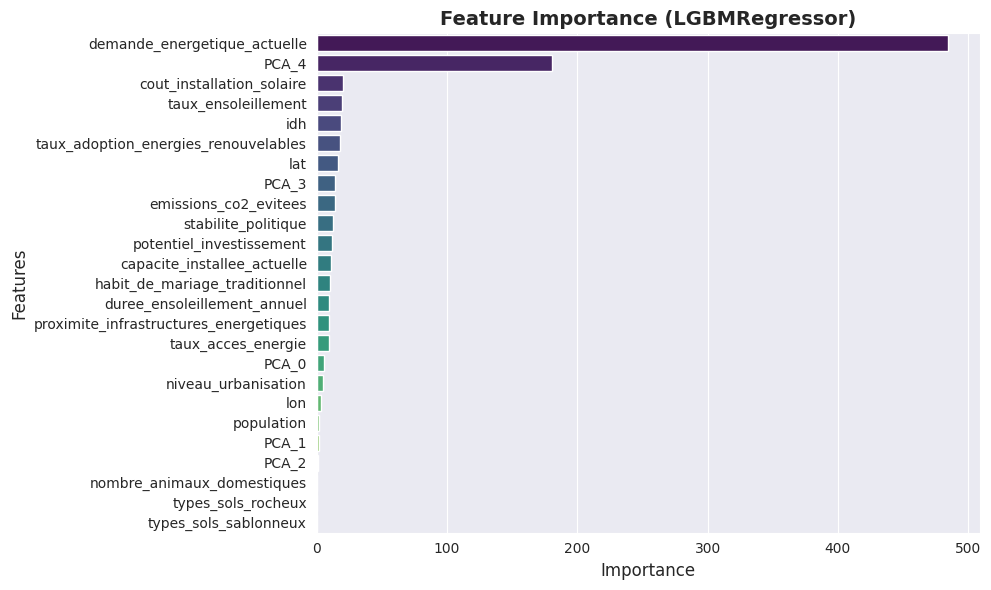

In [ ]:
plot_feature_importance(imp_hist, title="Feature Importance (LGBMRegressor)")

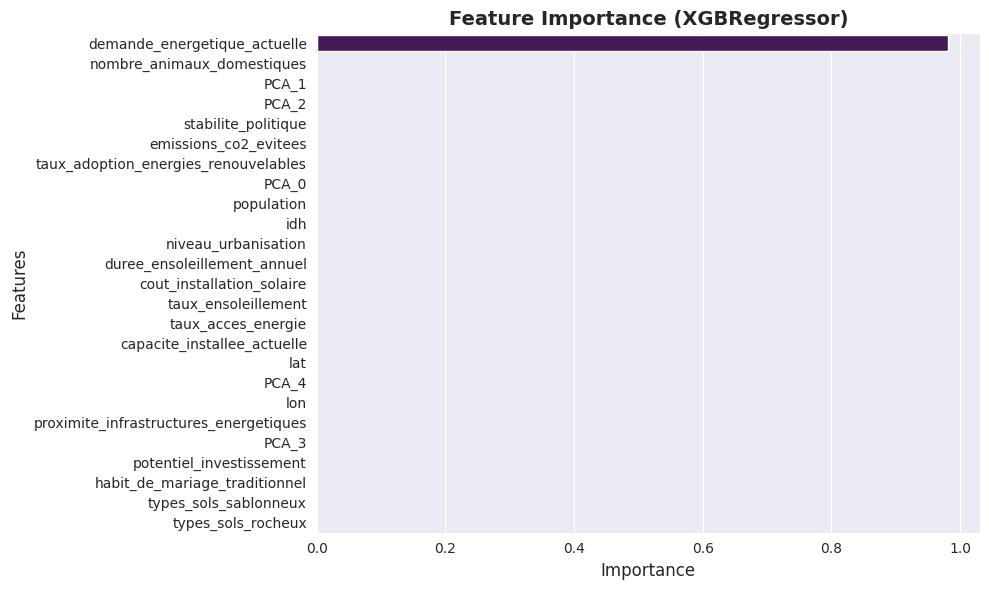

In [ ]:
plot_feature_importance(imp_xgb, title="Feature Importance (XGBRegressor)")

En principe, certaines variables pourraient/devraient être supprimées depuis le départ mais bon faute de temps...

In [ ]:
# prédictions d'ensemble sur le set de validation pour chaque méta-modèle
x_val = pd.DataFrame({
    'hist': np.round(hist_md.predict(X_val).tolist()),
    'lgb': np.round(lgb_md.predict(X_val).tolist()),
    'xgb': np.round(xgb_md.predict(X_val).tolist()),
    'cat': np.round(cat_md.predict(X_val).tolist()),
    'lr': np.round(lr_md.predict(X_val).tolist()),
    'gb': np.round(gb_md.predict(X_val).tolist()),
    'lasso': np.round(lasso_md.predict(X_val).tolist()),
})

# méta-modèles avec leurs noms et leurs scores de CV
meta_models = [
    {"name": "LAD Regression Ensemble", "model": lad_md, "cv_scores": lad_cv_scores},
    {"name": "Linear Regression Ensemble", "model": lr_ens_md, "cv_scores": lr_ens_cv_scores},
]

# evaluation des méta-modèles
meta_results = []
for meta_model_info in meta_models:
    name = meta_model_info["name"]
    model = meta_model_info["model"]
    cv_scores = meta_model_info["cv_scores"]

    print(f"{'=' * 40}")
    print(f"Evaluating: {name}")
    result = evaluate_model(model, x_val, Y_val, cv_scores, name)
    meta_results.append({"Model": name, **result})
    print(f"{'=' * 40}\n")

Evaluating: LAD Regression Ensemble
LAD Regression Ensemble - Score on CV test data             ======> 798.8638213033931
LAD Regression Ensemble - Score on Valid data (unseen data) ======> 800.2304911019336

Evaluating: Linear Regression Ensemble
Linear Regression Ensemble - Score on CV test data             ======> 798.8069499797055
Linear Regression Ensemble - Score on Valid data (unseen data) ======> 800.2821616337837



In [ ]:
# afficher le résumé des résultats
meta_results_df = pd.DataFrame(meta_results)
print("\nRésumé des résultats:")
display(meta_results_df)


Résumé des résultats:


Model    cv_score   val_score
0     LAD Regression Ensemble  798.863821  800.230491
1  Linear Regression Ensemble  798.806950  800.282162

**After Tuning:**


- **Linear regression scores:**  
Score on CV test data             ======> 798.9144668288485  
Score on Valid data (unseen data) ======> 800.1332855376303  

- **Lasso scores**  
Score on CV test data             ======> 798.9043259257681  
Score on Valid data (unseen data) ======> 800.1334426784532  

- **Gradient Boosting scores**  
Score on CV test data             ======> 799.5266503283077  
Score on Valid data (unseen data) ======> 800.1275653284664

- **Ligth GBM scores**  
Score on CV test data             ======> 799.2721719231226  
Score on Valid data (unseen data) ======> 800.2044259431666

- **HistGB scores**  
Score on CV test data             ======> 799.3449053748061  
Score on Valid data (unseen data) ======> 800.4738009586938

- **XGBoost scores**  
Score on CV test data             ======> 799.2986374770268  
Score on Valid data (unseen data) ======> 799.9783194224641

- **CatBoost scores**  
Score on CV test data             ======> 799.1398004625337  
Score on Valid data (unseen data) ======> 800.1159399293665

- **LAD ens scores**  
Score on CV test data             ======> 798.8834911398192  
Score on Valid data (unseen data) ======> 799.9976196393353


**feature eng**
-
LAD - Score on CV test data             ======> 798.8323670231811  
LAD - Score on Valid data (unseen data) ======> 800.0491036404799  
-
Linear Regression Ensemble - Score on CV test data ======> 798.7838164936836  
Linear Regression Ensemble - Score on Valid data (unseen data) ======> 799.9597970050114

## V. Soumission

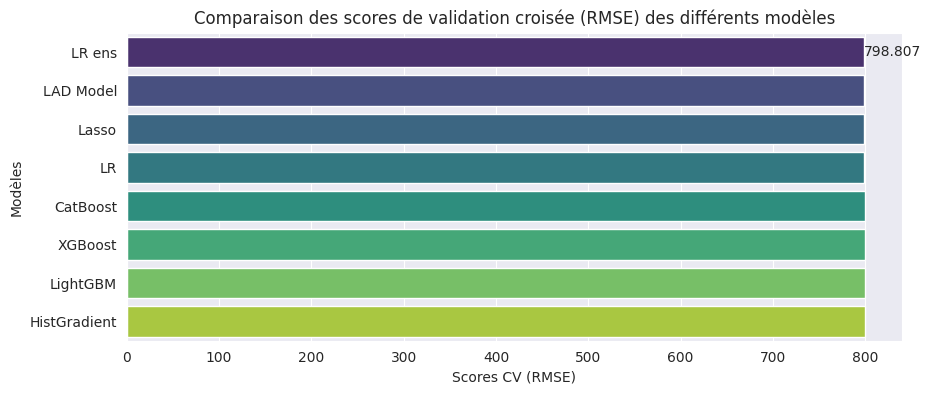

In [ ]:
#  moyenne des scores de validation croisée pour chaque modèle
lr_cv_score = np.mean(lr_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
cat_cv_score = np.mean(cat_cv_scores)
lasso_cv_score = np.mean(lasso_cv_scores)
lad_cv_score = np.mean(lad_cv_scores)
lr_ens_cv_score = np.mean(lr_ens_cv_scores)

# DataFrame avec tous les modèles et leurs scores moyens
model_perf = pd.DataFrame({
    'Models': ['LR', 'HistGradient', 'LightGBM', 'XGBoost', 'CatBoost', 'LAD Model', 'Lasso', 'LR ens'],
    'CV-scores': [lr_cv_score, hist_cv_score, lgb_cv_score, xgb_cv_score, cat_cv_score, lad_cv_score, lasso_cv_score, lr_ens_cv_score]
})

model_perf = model_perf.sort_values(by="CV-scores")

# performances des modèles
plt.figure(figsize=(10, 4))
ax = sns.barplot(y='Models', x='CV-scores', data=model_perf, palette="viridis")
ax.bar_label(ax.containers[0])
plt.title('Comparaison des scores de validation croisée (RMSE) des différents modèles')
plt.xlabel('Scores CV (RMSE)')
plt.ylabel('Modèles')
plt.show()

In [ ]:
submission[TARGET_COL] = pd.DataFrame(lad_preds).apply(np.mean, axis = 0)
submission['id'] = list(range(1, len(submission) + 1))
submission[['id','demande_energetique_projectee']].to_csv('New_LAD_Ensemble_Baseline_submission.csv', index = False)
print("Predictions saved to 'New_LAD_Ensemble_Baseline_submission.csv")

Predictions saved to 'New_LAD_Ensemble_Baseline_submission.csv


In [ ]:
submission[TARGET_COL] = pd.DataFrame(lr_ens_preds).apply(np.mean, axis = 0)
submission['id'] = list(range(1, len(submission) + 1))
submission[['id','demande_energetique_projectee']].to_csv('New_LR_Baseline_submission.csv', index = False)
print("Predictions saved to 'New_LR_Baseline_submission.csv")

Predictions saved to 'New_LR_Baseline_submission.csv


In [ ]:
stop


## VI. Hyperparameters Tuning

L'**optimisation bayésienne** est une méthode pour optimiser des hyperparamètres de modèles de manière efficace en utilisant un modèle probabiliste pour guider l'exploration de l'espace des hyperparamètres. Plutôt que d'explorer chaque combinaison de manière exhaustive, cette approche prédit les configurations qui sont probablement meilleures, en tenant compte des évaluations précédentes.

**Optuna** est une bibliothèque Python qui facilite l'optimisation bayésienne en automatisant la recherche des meilleurs hyperparamètres pour un modèle. Elle utilise des algorithmes comme **Tree-structured Parzen Estimator (TPE)** et **Gaussian Processes** pour explorer l'espace de recherche, rendant l'optimisation plus rapide et plus efficace.

In [ ]:
import optuna
from optuna.samplers import TPESampler

skf = KFold(n_splits = 5, random_state = RANDOM_STATE, shuffle = True)

In [ ]:
#  Optuna objective functions for each model
def optimize_lr(trial, X, Y):
    # No hyperparameters to optimize for Linear Regression
    return 0  # Placeholder

def optimize_lasso(trial, X, Y):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    max_iter = trial.suggest_int('max_iter', 500, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        lasso_md = Lasso(alpha=alpha, max_iter=max_iter, random_state=42)
        lasso_md.fit(X_train, Y_train)
        lasso_pred = lasso_md.predict(X_test)
        score = root_mean_squared_error(Y_test, lasso_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_gb(trial, X, Y):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        gb_md = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
        gb_md.fit(X_train, Y_train)
        gb_pred = gb_md.predict(X_test)
        score = root_mean_squared_error(Y_test, gb_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_lgb(trial, X, Y):
    num_leaves = trial.suggest_int('num_leaves', 10, 300)
    max_depth = trial.suggest_int('max_depth', -1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        lgb_md = LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, verbose=-1)
        lgb_md.fit(X_train, Y_train)
        lgb_pred = lgb_md.predict(X_test)
        score = root_mean_squared_error(Y_test, lgb_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_hist(trial, X, Y):
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        hist_md = HistGradientBoostingRegressor(max_iter=max_iter, max_depth=max_depth, learning_rate=learning_rate)
        hist_md.fit(X_train, Y_train)
        hist_pred = hist_md.predict(X_test)
        score = root_mean_squared_error(Y_test, hist_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_xgb(trial, X, Y):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        xgb_md = XGBRegressor(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=42)
        xgb_md.fit(X_train, Y_train)
        xgb_pred = xgb_md.predict(X_test)
        score = root_mean_squared_error(Y_test, xgb_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_cat(trial, X, Y):
    depth = trial.suggest_int('depth', 4, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    iterations = trial.suggest_int('iterations', 100, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        cat_md = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, verbose=0)
        cat_md.fit(X_train, Y_train)
        cat_pred = cat_md.predict(X_test)
        score = root_mean_squared_error(Y_test, cat_pred)
        scores.append(score)

    return np.mean(scores)

In [ ]:
# study and optimize each model
studies = {}
for model_name, objective in zip(['xgb', 'cat', 'gb'],
                                 [optimize_xgb, optimize_cat, optimize_gb]):
    study = optuna.create_study(direction='minimize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, X, Y), n_trials=50)
    studies[model_name] = study
    print(f"Best trial for {model_name} found with parameters: {study.best_params} and score: {study.best_value}")

In [ ]:
# results
for model_name, study in studies.items():
    print(f"\nModel: {model_name}")
    print("Best Score:", study.best_value)
    print("Best Parameters:", study.best_params)

# **Conclusion**

La phase nationale du challenge **DataTour 2024** a permis d'explorer la prévision de la demande énergétique en Afrique, un enjeu clé pour le développement durable et l'accès à l'électricité.

### **Impact et perspectives**
Les résultats montrent l'importance de l'IA pour anticiper les besoins énergétiques et orienter les décisions stratégiques, notamment pour :
- Identifier les zones prioritaires pour les infrastructures solaires.
- Informer les décideurs sur les régions nécessitant un soutien énergétique.
- Contribuer à la réduction des émissions de CO₂ grâce aux énergies renouvelables.

### **Limites et axes d’amélioration**
- L'analyse des données météorologiques pourrait affiner les prédictions.
- L'intégration de données en temps réel serait bénéfique.
- Une exploration des méthodes d'interprétabilité des modèles renforcerait la confiance dans les décisions.

En conclusion, cette expérience a relevé un défi technique tout en contribuant à l'amélioration de l'accès à l'énergie en Afrique, mettant en valeur l'impact des sciences des données dans la résolution de problèmes réels.

---

### **Auteurs**
Ce projet a été réalisé par l'équipe **A2H AI**, composée de :
- **Wendyellé Abubakrh Alban NYANTUDRE**  
  - ✉️ Email : nyantudrealban@gmail.com
  - 🌐 LinkedIn : [linkedin.com/in/anyantudre](https://www.linkedin.com/in/anyantudre/)
- **Haitam Bouanane**  
  - ✉️ Email :bouananehaitam03@gmail.com
  - 🌐 LinkedIn : [linkedin.com/in/haitam-bouanane-656783221](https://ma.linkedin.com/in/haitam-bouanane-656783221)  
- **Hatim Belfarhounia**  
  - ✉️ Email : nothatim@gmail.com
  - 🌐 LinkedIn : [linkedin.com/in/hatim-belfarhounia-7a8932291](https://www.linkedin.com/in/hatim-belfarhounia-7a8932291)   

Nous remercions chaleureusement **Data Afrique Hub** pour avoir fourni les datasets et organisé cette compétition exceptionnelle. Leur initiative contribue de manière significative à l'avancement de la Data Science en Afrique.

---